In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


# How to use the D2 Algorithm function:
# Set your thresholds (these need to be tuned based on the specific data)
# T1 = 3 * np.std(data['wf_i'][1][2500:2900])  # Example: 3 times the std of the noise baseline
# T2 = 0.053320  # This needs to be tuned based on your data

# detected_peaks = process_waveforms(waveforms, T1, T2)

def derivative_peak_detection(waveform, T1, T2):
    """
    Derivative-based peak detection algorithm.
    
    Args:
    waveform (np.array): Input waveform with n points.
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: Indices of detected peaks.
    """
    n = len(waveform)
    Output = []
    D1 = np.zeros(n)
    D2 = np.zeros(n)
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
        
        D1[i] = max(waveform[i] - waveform[i-1], 0)
        D2[i] = max(D1[i] - D1[i-1], 0)
        
        if D2[i] > 0:
            Int[i] = Int[i-1] + D2[i]
        elif Int[i-1] > T2:
            Output.append(i-1)
            Int[i] = 0  # Reset integration after detecting a peak
        else:
            Int[i] = 0  # Reset integration if no peak detected
    
    return Output


def process_waveforms(waveforms, T1, T2):
    """
    Process multiple waveforms using the derivative algorithm.

    Returns:
        list: List of detected peak indices for each waveform.
    """
    all_peaks = []
    for waveform in tqdm(waveforms, desc="Processing waveforms", unit="waveform"):
        peaks = derivative_peak_detection(waveform, T1, T2)
        all_peaks.append(peaks)
    return all_peaks

In [2]:
# Loading data
data = load_data("./processed_data_test/",
                     ["batch_0.npz",
                      "batch_1.npz",
                      "batch_2.npz",
                      "batch_3.npz",
                      "batch_4.npz",
                    ])

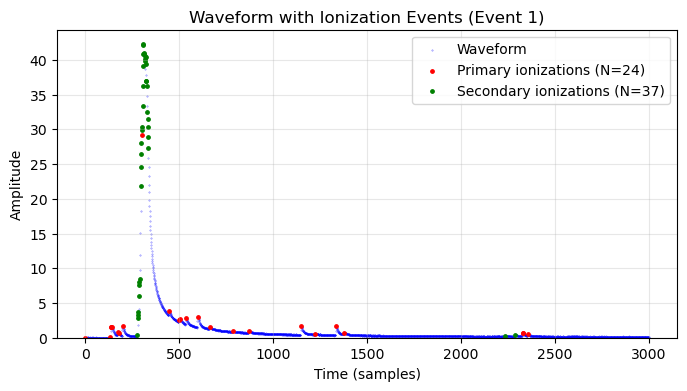

In [3]:
#Single event visualization

iev = 1
plt.figure(figsize=(8, 4))

plt.scatter(np.arange(data['wf_i'][iev].shape[0]), data['wf_i'][iev], s=0.1, 
           color='blue', alpha=0.6, label='Waveform')

primary_mask = data['tag_values'][iev] == 1
plt.scatter(data['tag_times'][iev, primary_mask], 
           data['wf_i'][iev][data['tag_times'][iev, primary_mask]], 
           s=6, color='r', label=f'Primary ionizations (N={np.sum(primary_mask)})')

secondary_mask = data['tag_values'][iev] == 2
plt.scatter(data['tag_times'][iev, secondary_mask], 
           data['wf_i'][iev][data['tag_times'][iev, secondary_mask]], 
           s=6, color='g', label=f'Secondary ionizations (N={np.sum(secondary_mask)})')

plt.ylim(0)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title(f'Waveform with Ionization Events (Event {iev})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<span style="font-size:24px">*Exploration about the Threshold (T1, T2)*</span>

In [ ]:
T1 = 5 * np.std(data['wf_i'][1][2500:2900])

# T1 = 7 * np.std(data['wf_i'][1][2500:2900])
# T2 = 0.04129

print(f"T1 threshold: {T1:.4f}")

testdata = {key: data[key][:1000] for key in data.keys()}
true_peak_counts = np.count_nonzero(testdata['tag_values'], axis=1)
mean_true_peaks = np.mean(true_peak_counts)

T1 threshold: 0.1266


T1 threshold: 0.1266
Scanning over T2 values...


Scanning T2: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


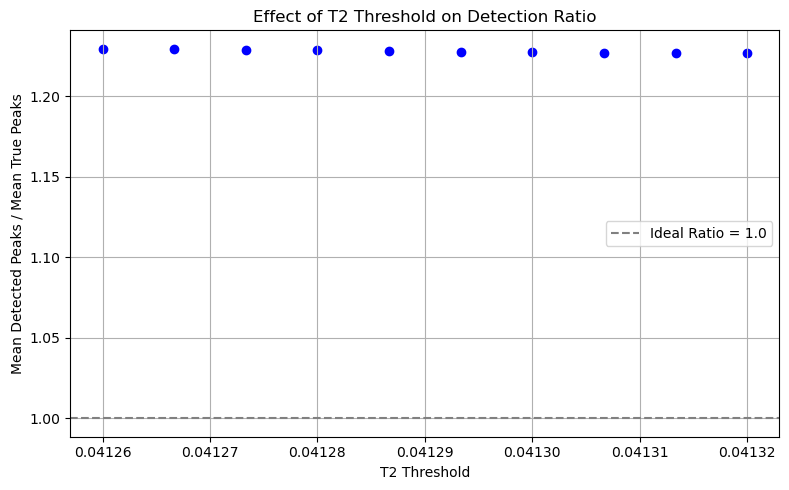

In [ ]:
print(f"T1 threshold: {T1:.4f}")

T2_values = np.linspace(0.04126, 0.04132, 10)
ratios = []

print("Scanning over T2 values...")
for T2 in tqdm(T2_values, desc="Scanning T2"):
    detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
    detected_peak_counts = [len(peaks) for peaks in detected_peaks]
    mean_detected = np.mean(detected_peak_counts)
    ratio = mean_detected / mean_true_peaks if mean_true_peaks > 0 else 0
    ratios.append(ratio)


plt.figure(figsize=(8, 5))
plt.scatter(T2_values, ratios, color='blue')
plt.axhline(y=1.0, color='gray', linestyle='--', label='Ideal Ratio = 1.0')
plt.xlabel("T2 Threshold")
plt.ylabel("Mean Detected Peaks / Mean True Peaks")
plt.title("Effect of T2 Threshold on Detection Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

T1 threshold: 0.1266
Scanning over T2 values...


Scanning T2: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


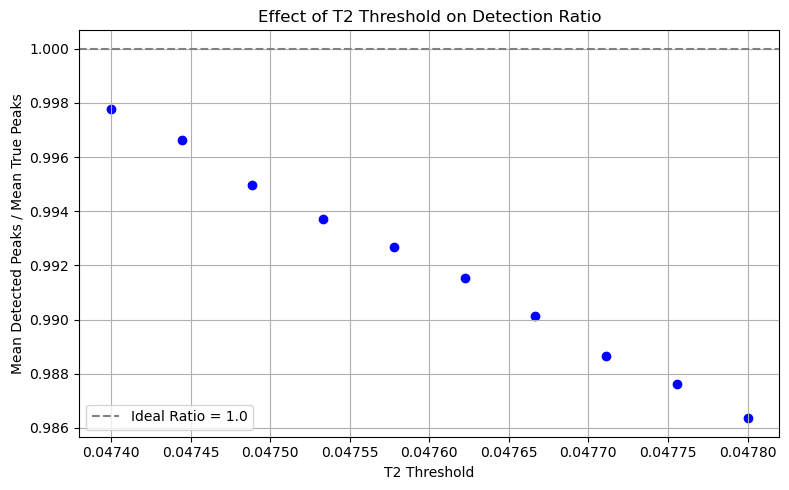

In [34]:
print(f"T1 threshold: {T1:.4f}")

T2_values = np.linspace(0.0474, 0.0478, 10)
ratios = []

print("Scanning over T2 values...")
for T2 in tqdm(T2_values, desc="Scanning T2"):
    detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
    detected_peak_counts = [len(peaks) for peaks in detected_peaks]
    mean_detected = np.mean(detected_peak_counts)
    ratio = mean_detected / mean_true_peaks if mean_true_peaks > 0 else 0
    ratios.append(ratio)


plt.figure(figsize=(8, 5))
plt.scatter(T2_values, ratios, color='blue')
plt.axhline(y=1.0, color='gray', linestyle='--', label='Ideal Ratio = 1.0')
plt.xlabel("T2 Threshold")
plt.ylabel("Mean Detected Peaks / Mean True Peaks")
plt.title("Effect of T2 Threshold on Detection Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<span style="font-size:24px">*Perform D2 prediction on the full dataset*</span>

Processing waveforms: 100%|██████████| 2000/2000 [00:04<00:00, 475.15waveform/s]


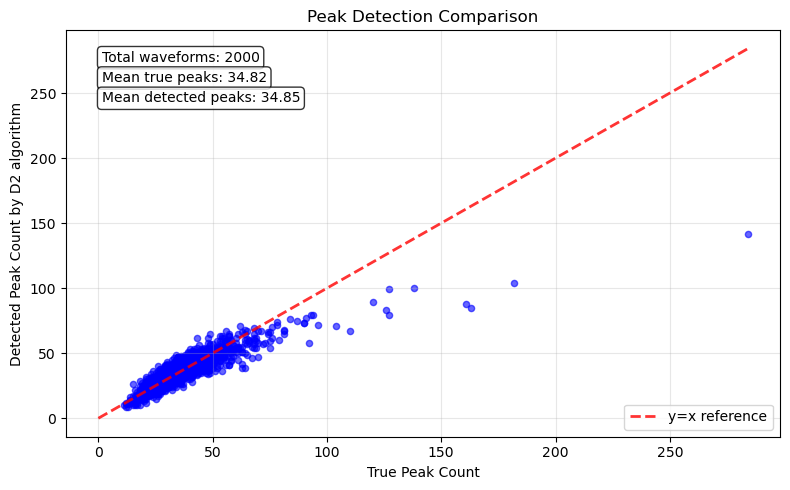

Correlation between true and detected peaks: 0.881
Standard deviation of true peaks: 14.68
Standard deviation of detected peaks: 11.56
Mean difference (detected - true): 0.03
Standard deviation of differences: 7.09
Mean absolute error: 4.15


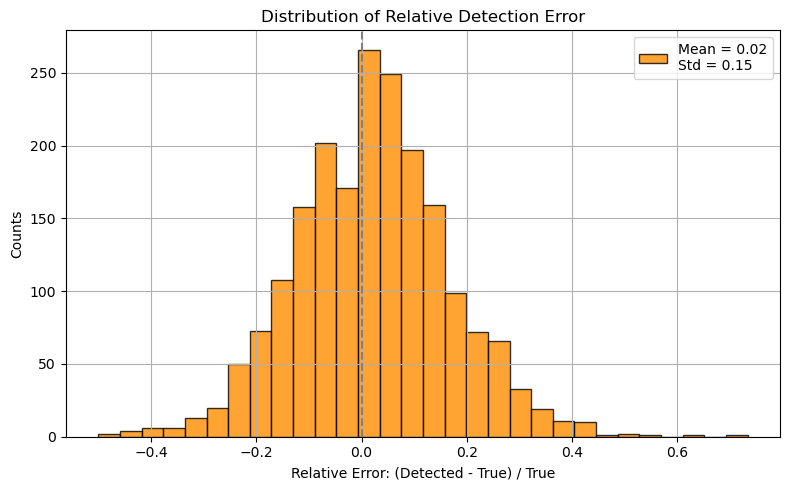

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


T1 = 3 * np.std(data['wf_i'][1][2500:2900])
T2 = 0.053320

plt.figure(figsize=(8, 5))

testdata = {key: data[key][:2000] for key in data.keys()}

detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
detected_peak_counts = [len(peaks) for peaks in detected_peaks]
true_peak_counts = np.count_nonzero(testdata['tag_values'], axis=1)

# Create scatter plot
plt.scatter(true_peak_counts, detected_peak_counts, alpha=0.6, s=20, color='blue')

# Add y=x reference line
max_val = max(np.max(true_peak_counts), np.max(detected_peak_counts))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y=x reference')

# Calculate correlation
correlation = np.corrcoef(true_peak_counts, detected_peak_counts)[0, 1]

plt.xlabel('True Peak Count')
plt.ylabel('Detected Peak Count by D2 algorithm')
plt.title(f'Peak Detection Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Add some statistics as text
plt.text(0.05, 0.95, f'Total waveforms: {len(true_peak_counts)}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.text(0.05, 0.90, f'Mean true peaks: {np.mean(true_peak_counts):.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.text(0.05, 0.85, f'Mean detected peaks: {np.mean(detected_peak_counts):.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


# Show distribution of differences
differences = np.array(detected_peak_counts) - np.array(true_peak_counts)

print(f"Correlation between true and detected peaks: {correlation:.3f}")
print(f"Standard deviation of true peaks: {np.std(true_peak_counts):.2f}")
print(f"Standard deviation of detected peaks: {np.std(detected_peak_counts):.2f}")
print(f"Mean difference (detected - true): {np.mean(differences):.2f}")
print(f"Standard deviation of differences: {np.std(differences):.2f}")
print(f"Mean absolute error: {np.mean(np.abs(differences)):.2f}")

with np.errstate(divide='ignore', invalid='ignore'):
    relative_errors = np.true_divide(detected_peak_counts - true_peak_counts, true_peak_counts)
    relative_errors[~np.isfinite(relative_errors)] = np.nan 


valid_errors = relative_errors[~np.isnan(relative_errors)]
mean_error = np.mean(valid_errors)
std_error = np.std(valid_errors)


plt.figure(figsize=(8, 5))
plt.hist(valid_errors, bins=30, color='darkorange', edgecolor='black', alpha=0.8,
         label=f"Mean = {mean_error:.2f}\nStd = {std_error:.2f}")
plt.axvline(0, color='gray', linestyle='--') 
plt.xlabel("Relative Error: (Detected - True) / True")
plt.ylabel("Counts")
plt.title("Distribution of Relative Detection Error")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

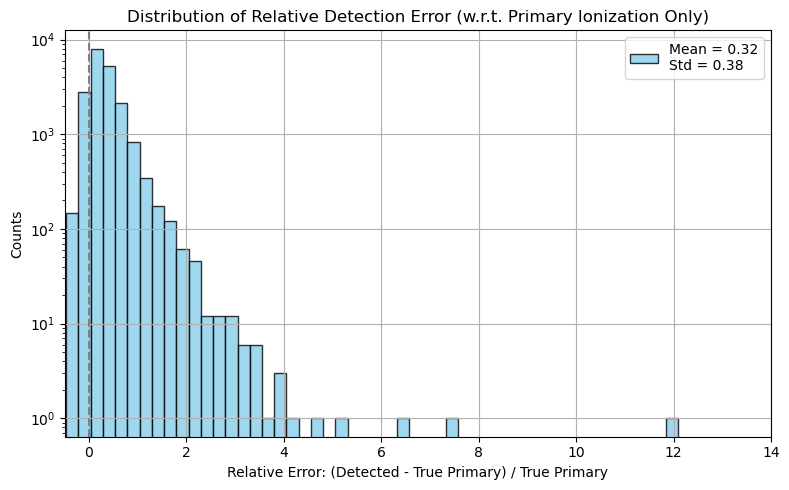

In [ ]:
true_primary_peak_counts = np.sum(testdata['tag_values'] == 1, axis=1)

with np.errstate(divide='ignore', invalid='ignore'):
    primary_relative_errors = np.true_divide(detected_peak_counts - true_primary_peak_counts, true_primary_peak_counts)
    primary_relative_errors[~np.isfinite(primary_relative_errors)] = np.nan  

valid_primary_errors = primary_relative_errors[~np.isnan(primary_relative_errors)]
mean_primary_error = np.mean(valid_primary_errors)
std_primary_error = np.std(valid_primary_errors)

plt.figure(figsize=(8, 5))
plt.hist(valid_primary_errors, bins=50, color='skyblue', edgecolor='black', alpha=0.8,
         label=f"Mean = {mean_primary_error:.2f}\nStd = {std_primary_error:.2f}")
plt.axvline(0, color='gray', linestyle='--') 
plt.xlabel("Relative Error: (Detected - True Primary) / True Primary")
plt.xlim(-0.5, 14)
plt.yscale('log')
plt.ylabel("Counts")
plt.title("Distribution of Relative Detection Error (w.r.t. Primary Ionization Only)")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


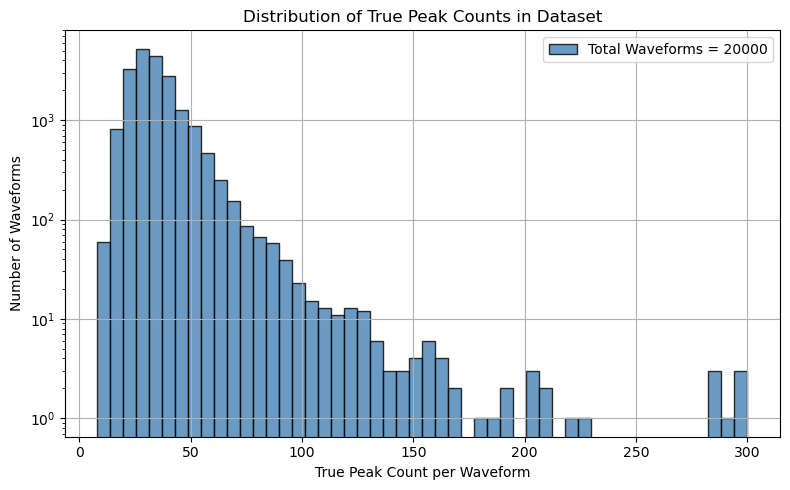

Number of waveforms with >100 true peaks: 113


In [44]:
total_waveforms = len(true_peak_counts)

plt.figure(figsize=(8, 5))
plt.hist(true_peak_counts, bins=50, color='steelblue', edgecolor='black', alpha=0.8,
         label=f"Total Waveforms = {total_waveforms}")
plt.xlabel("True Peak Count per Waveform")
plt.yscale('log')
plt.ylabel("Number of Waveforms")
plt.title("Distribution of True Peak Counts in Dataset")
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()


high_peak_indices = np.where(true_peak_counts > 100)[0]

print(f"Number of waveforms with >100 true peaks: {len(high_peak_indices)}")

high_count_data = {key: data[key][high_peak_indices] for key in data.keys()}

<span style="font-size:24px">*Calibration Method*</span>

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tag_times_by_calibration(train_data):
    tag_values = train_data['tag_values']
    tag_times = train_data['tag_times']

    raw_peaks = tag_times[tag_values > 0]
    primary = tag_times[tag_values == 1]
    secondary = tag_times[tag_values == 2]

    # Histogram: 1000 bins (for display)
    hist_bins = 1000
    all_data = np.concatenate([raw_peaks, primary, secondary])
    hist_bin_edges = np.histogram_bin_edges(all_data, bins=hist_bins)

    # Ratio calculation: 250 bins
    ratio_bins = 250
    ratio_bin_edges = np.histogram_bin_edges(all_data, bins=ratio_bins)
    ratio_bin_centers = (ratio_bin_edges[:-1] + ratio_bin_edges[1:]) / 2

    raw_counts_ratio, _ = np.histogram(raw_peaks, bins=ratio_bin_edges)
    primary_counts, _ = np.histogram(primary, bins=ratio_bin_edges)

    raw_counts_safe = np.where(raw_counts_ratio == 0, 1e-6, raw_counts_ratio)
    primary_ratio = primary_counts / raw_counts_safe  # <-- no percent conversion here

    # Save data: (start_edge, end_edge, ratio)
    ratio_data = []
    for i in range(len(ratio_bin_edges) - 1):
        start = ratio_bin_edges[i]
        end = ratio_bin_edges[i + 1]
        ratio = primary_ratio[i]
        ratio_data.append((start, end, ratio))

    # Optional: convert to numpy array
    ratio_data_array = np.array(ratio_data)

    # ---- Plotting ----
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax2.plot(ratio_bin_centers, primary_ratio * 100, color='green', linestyle='--', marker='o', label='Primary Ionization Percentage (%)')

    ax1.set_xlim(0, 3000)
    ax2.set_xlim(0, 3000)

    ax1.set_xlabel('Time Position')
    ax1.set_ylabel('Frequency')
    ax2.set_ylabel('Ratio to Electron (%)')

    ax1.set_title('Calibration Curve')
    ax1.grid(True, alpha=0.3)

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

    return ratio_data_array  # Return the data


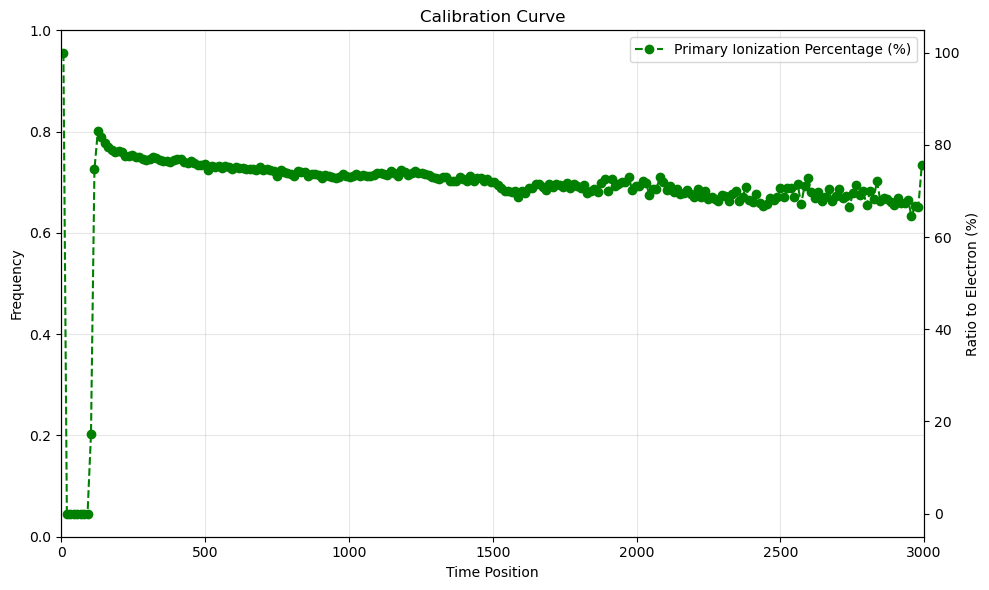

Bin: [1.00, 12.99], Primary Ratio: 0.9983
Bin: [12.99, 24.98], Primary Ratio: 0.0000
Bin: [24.98, 36.96], Primary Ratio: 0.0000
Bin: [36.96, 48.95], Primary Ratio: 0.0000
Bin: [48.95, 60.94], Primary Ratio: 0.0000
Bin: [60.94, 72.93], Primary Ratio: 0.0000
Bin: [72.93, 84.92], Primary Ratio: 0.0000
Bin: [84.92, 96.90], Primary Ratio: 0.0000
Bin: [96.90, 108.89], Primary Ratio: 0.1728
Bin: [108.89, 120.88], Primary Ratio: 0.7467


Processing waveforms:   2%|▏         | 9547/400000 [00:19<12:58, 501.31waveform/s]


KeyboardInterrupt: 

In [9]:
calibration_data_num = 100000
calibration_data = {key: data[key][:calibration_data_num] for key in data.keys()}
prediction_data = {key: data[key][calibration_data_num:] for key in data.keys()}
ratio_table = plot_tag_times_by_calibration(calibration_data)

# Preview first 5 entries
for r in ratio_table[:10]:
    print(f"Bin: [{r[0]:.2f}, {r[1]:.2f}], Primary Ratio: {r[2]:.4f}")

def estimate_primary_peaks_by_ratio_table(detected_peaks, ratio_table):
    """
    Estimate primary ionization counts using detected peaks and ratio calibration table.
    
    Args:
        detected_peaks (list of lists): Detected peak indices for each waveform.
        ratio_table (np.array): Array of shape (n_bins, 3) with [start, end, ratio] per bin.
    
    Returns:
        list: Estimated primary peak counts per waveform (as float).
    """
    estimated_primary_counts = []

    bin_starts = ratio_table[:, 0]
    bin_ends = ratio_table[:, 1]
    bin_ratios = ratio_table[:, 2]

    for peaks in tqdm(detected_peaks, desc="Estimating primary counts", unit="waveform"):
        primary_count = 0.0
        for peak in peaks:
            bin_idx = np.where((peak >= bin_starts) & (peak < bin_ends))[0]
            if len(bin_idx) > 0:
                primary_count += bin_ratios[bin_idx[0]]
        estimated_primary_counts.append(primary_count)
    
    return estimated_primary_counts

detected_prediction_peaks = process_waveforms(prediction_data['wf_i'], T1, T2)
detected_primary_peak_counts = estimate_primary_peaks_by_ratio_table(detected_prediction_peaks, ratio_table)
true_primary_peak_counts = np.sum(prediction_data['tag_values'] == 1, axis=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

true_primary_peak_counts = np.array(true_primary_peak_counts)
detected_primary_peak_counts = np.array(detected_primary_peak_counts)

plt.figure(figsize=(10, 8))


plt.scatter(true_primary_peak_counts, detected_primary_peak_counts, alpha=0.6, s=20, color='green')

max_val = max(np.max(true_primary_peak_counts), np.max(detected_primary_peak_counts))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y=x reference')

correlation = np.corrcoef(true_primary_peak_counts, detected_primary_peak_counts)[0, 1]

plt.xlabel('True Primary Peak Count')
plt.ylabel('Estimated Primary Peak Count (Calibrated)')
plt.title('Primary Peak Count Comparison (Calibration-Based)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.text(0.05, 0.95, f'Total waveforms: {len(true_primary_peak_counts)}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.text(0.05, 0.90, f'Mean true: {np.mean(true_primary_peak_counts):.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.text(0.05, 0.85, f'Mean estimated: {np.mean(detected_primary_peak_counts):.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

diff = detected_primary_peak_counts - true_primary_peak_counts
print(f"Correlation: {correlation:.3f}")
print(f"Mean difference (estimated - true): {np.mean(diff):.2f}")
print(f"Standard deviation of differences: {np.std(diff):.2f}")
print(f"Mean absolute error: {np.mean(np.abs(diff)):.2f}")





with np.errstate(divide='ignore', invalid='ignore'):
    relative_errors_primary = np.true_divide(
        detected_primary_peak_counts - true_primary_peak_counts,
        true_primary_peak_counts
    )
    relative_errors_primary[~np.isfinite(relative_errors_primary)] = np.nan

valid_errors_primary = relative_errors_primary[~np.isnan(relative_errors_primary)]

mean_error_primary = np.mean(valid_errors_primary)
std_error_primary = np.std(valid_errors_primary)

plt.figure(figsize=(8, 5))
plt.hist(valid_errors_primary, bins=50, color='seagreen', edgecolor='black', alpha=0.8,
         label=f"Mean = {mean_error_primary:.2f}\nStd = {std_error_primary:.2f}")
plt.axvline(0, color='gray', linestyle='--') 
plt.xlabel("Relative Error: (Estimated - True) / True")
plt.ylabel("Counts")
plt.xlim(-1, 14)
# plt.yscale('log')
plt.title("Distribution of Relative Error (Primary Peaks)")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


NameError: name 'detected_primary_peak_counts' is not defined

<span style="font-size:24px">*Clusterization Method*</span>

In [3]:
# Extract true peaks from labels

def extract_true_peaks_from_labels(testdata):
    """
    Extract true peak positions from labels where tag_values = 1 or 2.
    
    Returns:
        list: List of true peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1 and 2
        peak_mask = (tag_values[i] == 1) | (tag_values[i] == 2)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

def extract_true_primary_peaks_from_labels(testdata):
    """
    Extract true primary peak positions from labels where tag_values = 1.
    
    Returns:
        list: List of true primary peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true primary peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1
        peak_mask = (tag_values[i] == 1)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

In [4]:
# Fixed Clusterization Method

def estimate_primary_from_cluster_window(detected_peaks, b, c, d):
    """
    Estimate the number of primary ionizations per waveform by merging nearby peaks in a sliding window.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Number of units to look forward in time window.
        c (float): Normalization factor (divides peak count in window).
        d (float): Maximum number of peaks in window.
    Returns:
        list: Estimated number of primary ionizations (float) for each waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:

        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current
            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d*c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts

def collect_cluster_peaks(detected_peaks, b, c, d):
    """
    For each waveform, return a list of peak lists used in each cluster count step.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Window size to look forward.
        c (float): Normalization factor.
        d (float): Maximum number of peaks allowed in window.
    
    Returns:
        list of lists: Each inner list contains the peak values used at each cluster step.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current

            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            # Determine how many peaks to take from this cluster
            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            # Store the first n peaks in this cluster (or fewer if not enough)
            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def find_best_indices_3d(data, mode="mean"):
    if mode == "mean":
        idx = np.unravel_index(np.argmin(np.abs(data)), data.shape)
    elif mode == "std":
        idx = np.unravel_index(np.argmin(data), data.shape)
    return idx

def plot_heatmap_2d_slice(data_3d, d_idx, title, x_labels, y_labels, x_name, y_name, cmap='viridis', highlight=None):
    data = data_3d[:, :, d_idx]
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data, origin='lower', cmap=cmap,
                    extent=[x_labels[0], x_labels[-1], y_labels[0], y_labels[-1]],
                    aspect='auto')

    cbar = plt.colorbar(im, format="%.4f")
    cbar.ax.tick_params(labelsize=10)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f"{title} (d = {d_values[d_idx]})")

    if highlight:
        i, j, _ = highlight
        x_val = x_labels[j]
        y_val = y_labels[i]
        plt.plot(x_val, y_val, 'ro', markersize=8, label='Best Point')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
# Adaptive Clusterization Method

import itertools

region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 1550),
        'r4': (1550, 3000),
    }
# region_bounds = {
    #     'r1': (0, 130),
    #     'r2': (130, 1600),
    #     'r3': (1600, 3000),
    # }

def estimate_primary_from_cluster_window_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Adaptive estimation of primary ionizations per waveform using different parameters for different time regions.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Keys are region names ('r1', 'r2', ...), values are parameter values.
    
    Returns:
        list: Estimated primary ionizations per waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]

            # Determine region
            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d * c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts


def collect_cluster_peaks_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Collect cluster peaks per waveform with region-adapted parameters.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Region-specific parameter mappings.

    Returns:
        list of lists: Each inner list contains peak lists used in each cluster.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]

            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def scan_adaptive_parameters_region_wise(detected_peaks, true_primary_peaks):
    """
    Scan optimal parameters for each region using true primary peaks.
    
    Args:
        detected_peaks (list): List of detected peak positions for each waveform
        true_primary_peaks (list): List of true primary peak positions for each waveform (from extract_true_primary_peaks_from_labels)
    """

    b_values = np.arange(1, 100, 1)
    c_values = np.arange(0.8, 2.0, 0.1)
    d_values = np.arange(1, 6, 1)
    
    best_params = {}
    region_results = {}
    
    for region, (low, high) in region_bounds.items():
        print(f"Scanning parameters for region {region} ({low}-{high})")
        
        region_detected_peaks = []
        region_true_counts = []
        
        for i, peaks in enumerate(detected_peaks):
            region_peaks = [p for p in peaks if low <= p < high]
            true_peaks_in_region = [p for p in true_primary_peaks[i] if low <= p < high]
            true_count_in_region = len(true_peaks_in_region)
            if region_peaks:
                region_detected_peaks.append(region_peaks)
                region_true_counts.append(true_count_in_region)
        
        if not region_detected_peaks:
            best_params[region] = {'b': 10, 'c': 1.0, 'd': 2}
            region_results[region] = float('inf')
            print(f"No detected peaks in region {region}, using default parameters")
            continue
        
        region_true_counts = np.array(region_true_counts)
        
        best_score = float('inf')
        best_region_params = None
        
        for b, c, d in tqdm(list(itertools.product(b_values, c_values, d_values)), 
                           desc=f"Region {region}"):
            
            temp_b_map = {r: 10 for r in region_bounds.keys()}
            temp_c_map = {r: 1.0 for r in region_bounds.keys()}
            temp_d_map = {r: 2 for r in region_bounds.keys()}
            
            temp_b_map[region] = int(b)
            temp_c_map[region] = float(c)
            temp_d_map[region] = int(d)
            
            estimated_counts = []
            for peaks in region_detected_peaks:
                count = estimate_single_region_count(peaks, b, c, d)
                estimated_counts.append(count)
            
            estimated_counts = np.array(estimated_counts)
            
            # Calculate relative errors: (estimated - true) / true
            with np.errstate(divide='ignore', invalid='ignore'):
                relative_errors = (estimated_counts - region_true_counts) / region_true_counts
                # Handle division by zero and invalid values
                relative_errors = relative_errors[np.isfinite(relative_errors)]
            
            # Calculate score based on relative errors
            if len(relative_errors) > 0:
                score = np.abs(np.mean(relative_errors))  # Mean squared relative error
            else:
                score = float('inf')  # If no valid relative errors, set high score
            
            if score < best_score:
                best_score = score
                best_region_params = {'b': b, 'c': c, 'd': d}
                # print(f"Best score: {score:.4f}")
                # print(f"Best params: {best_region_params}")
        
        best_params[region] = best_region_params
        region_results[region] = best_score
        print(f"Best params for {region}: {best_region_params}, Score: {best_score:.4f}")
    
    return best_params, region_results

def estimate_single_region_count(peaks, b, c, d):
    if not peaks:
        return 0.0
    
    peaks = sorted(peaks)
    remaining_peaks = peaks.copy()
    count = 0.0
    
    while remaining_peaks:
        current = remaining_peaks[0]
        window_start = current
        window_end = current + b
        
        cluster = [p for p in remaining_peaks if window_start <= p <= window_end]
        
        if len(cluster) <= c:
            count += 1
        elif d * c > len(cluster) > c:
            count += len(cluster) / c
        else:
            count += d
        
        remaining_peaks = [p for p in remaining_peaks if p not in cluster]
    
    return count

def run_adaptive_parameter_optimization(detected_peak, true_primary_peaks):
    """Complete adaptive parameter optimization workflow"""
    
    print("Starting adaptive parameter scanning...")
    
    # Step 1: Parameter scanning
    best_params, region_results = scan_adaptive_parameters_region_wise(
        detected_peak, 
        true_primary_peaks
    )
    
    # Step 2: Format conversion
    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}
    
    # Step 3: Final prediction
    adaptive_estimates = estimate_primary_from_cluster_window_adaptive(
        detected_peak, b_map, c_map, d_map
    )
    
    # Step 4: Compare with fixed parameter method
    # Use default fixed parameters
    fixed_estimates = estimate_primary_from_cluster_window(
        detected_peak, b=24, c=1.60, d=2
    )
    # fixed_estimates = estimate_primary_from_cluster_window(
    #     detected_peak, b=69, c=0.899, d=3
    # )

    true_primary_peak_counts = [len(peaks) for peaks in true_primary_peaks]
    true_primary_peak_counts = np.array(true_primary_peak_counts)
    adaptive_estimates = np.array(adaptive_estimates)
    fixed_estimates = np.array(fixed_estimates)
    
    
    # Step 5: Performance comparison
    adaptive_mae = np.mean(np.abs(adaptive_estimates - true_primary_peak_counts))
    fixed_mae = np.mean(np.abs(fixed_estimates - true_primary_peak_counts))
    
    print(f"\nPerformance comparison:")
    print(f"Adaptive method MAE: {adaptive_mae:.4f}")
    print(f"Fixed parameter method MAE: {fixed_mae:.4f}")
    print(f"Improvement: {((fixed_mae - adaptive_mae) / fixed_mae * 100):.2f}%")
    
    # Step 6: Visualization
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Parameter distribution
    plt.subplot(2, 2, 1)
    regions = list(best_params.keys())
    b_values = [best_params[r]['b'] for r in regions]
    plt.bar(regions, b_values)
    plt.title('Optimal b parameters by region')
    plt.ylabel('b value')
    
    plt.subplot(2, 2, 2)
    c_values = [best_params[r]['c'] for r in regions]
    plt.bar(regions, c_values)
    plt.title('Optimal c parameters by region')
    plt.ylabel('c value')
    
    # Subplot 3: Prediction comparison
    plt.subplot(2, 2, 3)
    adaptive_corr = np.corrcoef(true_primary_peak_counts, adaptive_estimates)[0, 1]
    fixed_corr = np.corrcoef(true_primary_peak_counts, fixed_estimates)[0, 1]

    plt.scatter(true_primary_peak_counts, adaptive_estimates, alpha=0.6, label=f'Adaptive (R={adaptive_corr:.3f})')
    plt.scatter(true_primary_peak_counts, fixed_estimates, alpha=0.6, label=f'Fixed (R={fixed_corr:.3f})')
    plt.plot([0, max(true_primary_peak_counts)], [0, max(true_primary_peak_counts)], 'r--')
    plt.xlabel('True Counts')
    plt.ylabel('Estimated Counts')
    plt.legend()
    plt.title('Prediction accuracy comparison')
    
    # Subplot 4: Error distribution
    plt.subplot(2, 2, 4)
    with np.errstate(divide='ignore', invalid='ignore'):
        adaptive_rel_errors = (np.array(adaptive_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        fixed_rel_errors = (np.array(fixed_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        adaptive_rel_errors = adaptive_rel_errors[np.isfinite(adaptive_rel_errors)]
        fixed_rel_errors = fixed_rel_errors[np.isfinite(fixed_rel_errors)]

    # Calculate mean and std for relative errors
    adaptive_rel_mean = np.mean(adaptive_rel_errors)
    adaptive_rel_std = np.std(adaptive_rel_errors)
    fixed_rel_mean = np.mean(fixed_rel_errors)
    fixed_rel_std = np.std(fixed_rel_errors)

    plt.hist(adaptive_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Adaptive (μ={adaptive_rel_mean:.3f}, σ={adaptive_rel_std:.3f})', density=False)
    plt.hist(fixed_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Fixed (μ={fixed_rel_mean:.3f}, σ={fixed_rel_std:.3f})', density=False)
    plt.xlabel('Relative Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Relative error distribution comparison')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': best_params,
        'b_map': b_map,
        'c_map': c_map,
        'd_map': d_map,
        'adaptive_estimates': adaptive_estimates,
        'region_results': region_results
    }

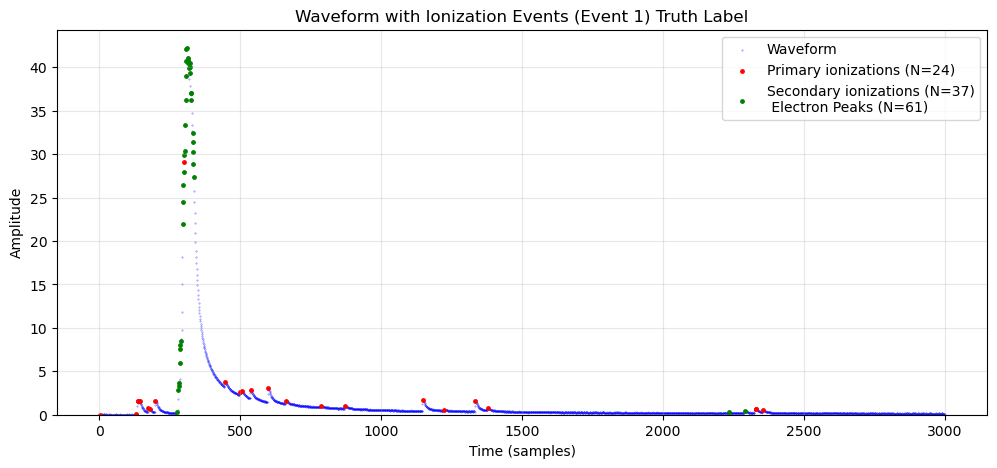

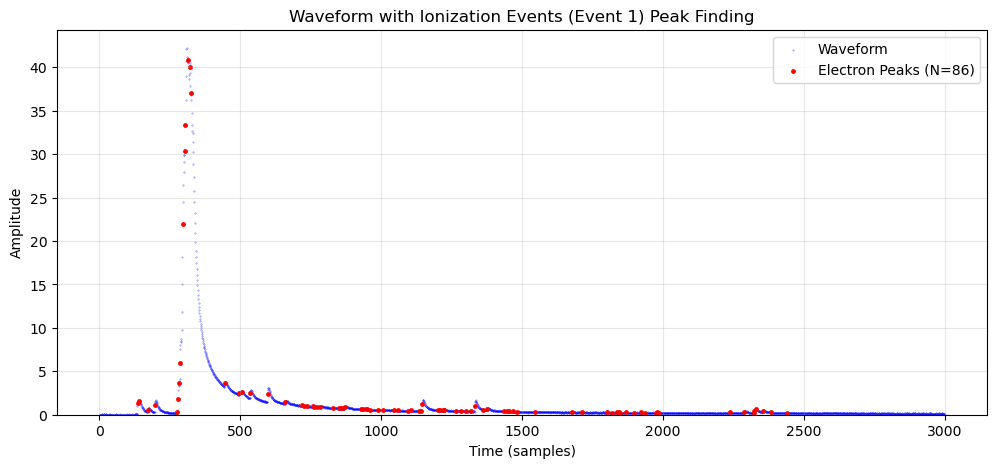

43


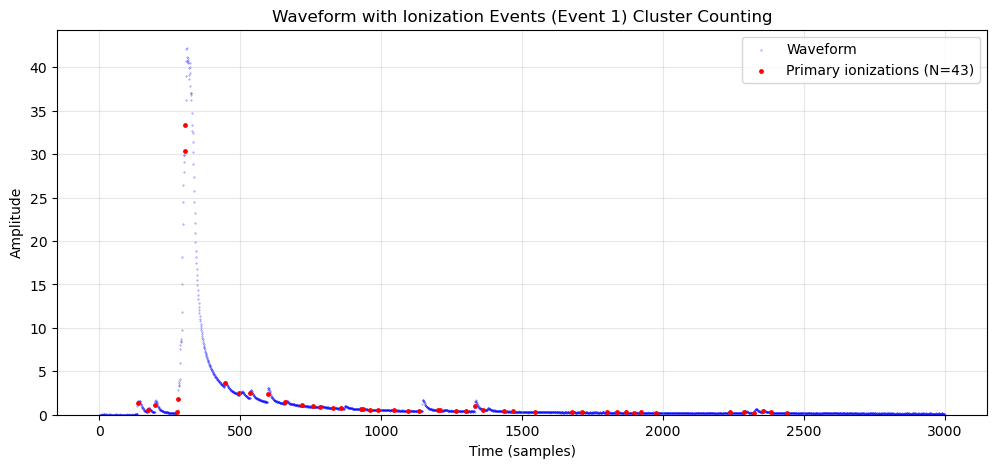

In [29]:
iev = 1
plt.figure(figsize=(12, 5))

plt.scatter(np.arange(data['wf_i'][iev].shape[0]), data['wf_i'][iev], s=0.1, 
           color='blue', alpha=0.6, label='Waveform')

primary_mask = data['tag_values'][iev] == 1
plt.scatter(data['tag_times'][iev, primary_mask], 
           data['wf_i'][iev][data['tag_times'][iev, primary_mask]], 
           s=6, color='r', label=f'Primary ionizations (N={np.sum(primary_mask)})')

secondary_mask = data['tag_values'][iev] == 2
plt.scatter(data['tag_times'][iev, secondary_mask], 
           data['wf_i'][iev][data['tag_times'][iev, secondary_mask]], 
           s=6, color='g', label=f'Secondary ionizations (N={np.sum(secondary_mask)})\n Electron Peaks (N={np.sum(primary_mask)+np.sum(secondary_mask)})')

plt.ylim(0)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title(f'Waveform with Ionization Events (Event {iev}) Truth Label')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


predicted_event_raw_peak_mask = detected_peaks[iev]
predicted_peak_y_values = data['wf_i'][iev][predicted_event_raw_peak_mask]


plt.figure(figsize=(12, 5))

plt.scatter(np.arange(data['wf_i'][iev].shape[0]), data['wf_i'][iev], s=0.1, 
           color='blue', alpha=0.6, label='Waveform')

plt.scatter(predicted_event_raw_peak_mask, predicted_peak_y_values, 
           s=6, color='red', label=f'Electron Peaks (N={len(predicted_event_raw_peak_mask)})')

plt.ylim(0)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title(f'Waveform with Ionization Events (Event {iev}) Peak Finding')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

primary_counts_fixed_mask = collect_cluster_peaks(detected_peaks, b=24, c=1.60, d=2)[iev]
print(len(primary_counts_fixed_mask))
flat_peaks = [p for sublist in primary_counts_fixed_mask for p in sublist]
predicted_cluster_y_values = data['wf_i'][iev][flat_peaks]

plt.figure(figsize=(12, 5))

plt.scatter(np.arange(data['wf_i'][iev].shape[0]), data['wf_i'][iev], s=0.1, 
           color='blue', alpha=0.6, label='Waveform')

plt.scatter(flat_peaks, predicted_cluster_y_values, 
           s=6, color='red', label=f'Primary ionizations (N={len(primary_counts_fixed_mask)})')

plt.ylim(0)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title(f'Waveform with Ionization Events (Event {iev}) Cluster Counting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
# Fixed Clusterization Method


b_values = np.arange(1, 100, 1)
c_values = np.arange(0.5, 3.0, 0.1)
d_values = np.arange(1, 6, 1)


mean_diff_map = np.zeros((len(b_values), len(c_values), len(d_values)))
std_diff_map = np.zeros((len(b_values), len(c_values), len(d_values)))

mean_diff_map_abs = np.zeros((len(b_values), len(c_values), len(d_values)))
std_diff_map_abs = np.zeros((len(b_values), len(c_values), len(d_values)))

for i, b in enumerate(tqdm(b_values, desc="Scanning b")):
    for j, c in enumerate(c_values):
        for k, d in enumerate(d_values):
            primary_counts_est = estimate_primary_from_cluster_window(detected_peaks, b=b, c=c, d=d)
            primary_counts_est = np.array(primary_counts_est)

            abs_diff = primary_counts_est - true_primary_peak_counts
            mean_diff_map_abs[i, j, k] = np.mean(abs_diff)
            std_diff_map_abs[i, j, k] = np.std(abs_diff)

            with np.errstate(divide='ignore', invalid='ignore'):
                relative_errors = np.true_divide(
                    primary_counts_est - true_primary_peak_counts,
                    true_primary_peak_counts
                )
                relative_errors[~np.isfinite(relative_errors)] = np.nan

            valid_errors = relative_errors[~np.isnan(relative_errors)]
            mean_diff_map[i, j, k] = np.mean(valid_errors)
            std_diff_map[i, j, k] = np.std(valid_errors)

Scanning b: 100%|██████████| 99/99 [1:16:26<00:00, 46.33s/it]


Best mean ~0 at b=14, c=1.9999999999999996, d=2 → mean = 0.0000, std = 0.2763
Best std min at b=99, c=0.5, d=1 → mean = -0.5892, std = 0.0867


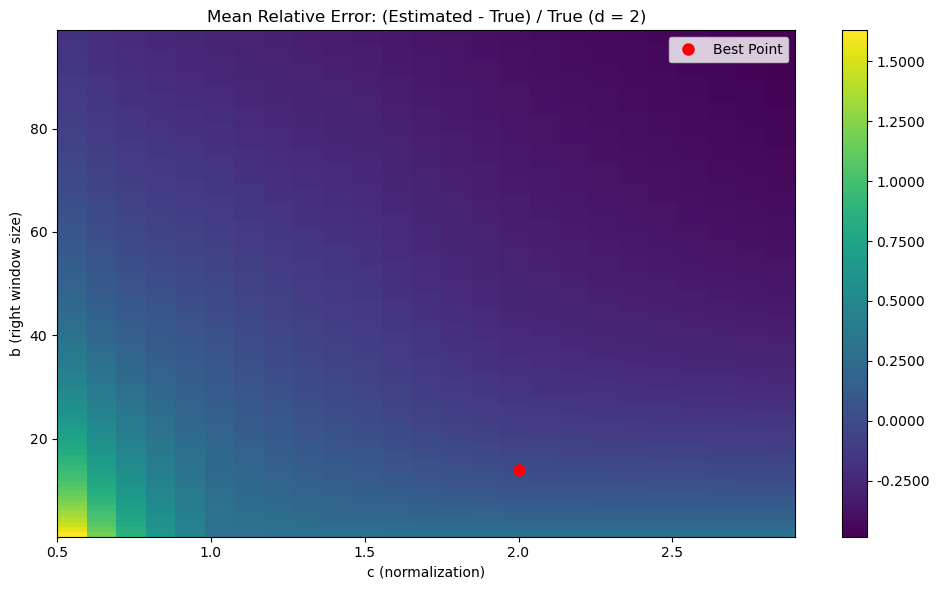

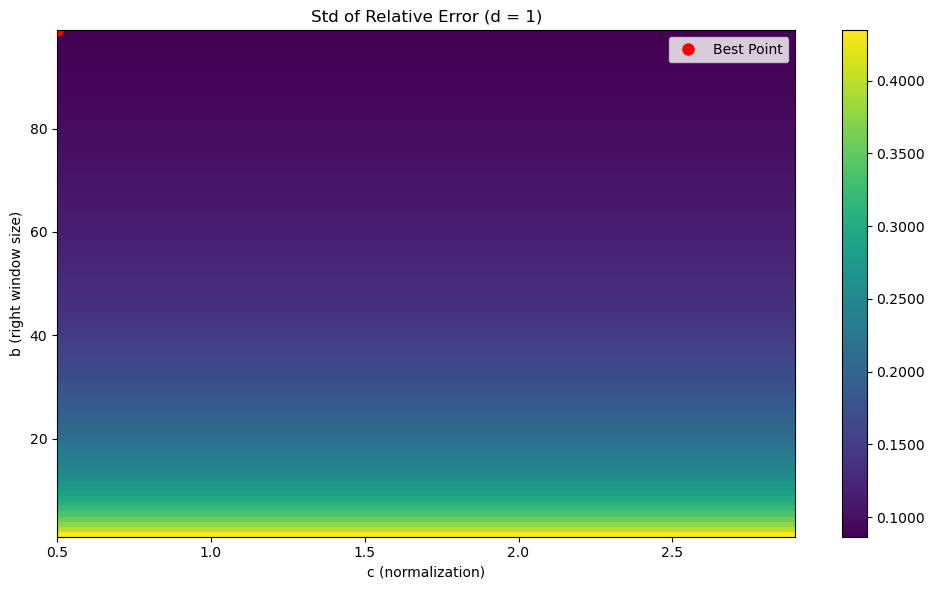

In [76]:
best_mean_idx = find_best_indices_3d(mean_diff_map, mode="mean")
best_std_idx = find_best_indices_3d(std_diff_map, mode="std")

best_mean_val = mean_diff_map[best_mean_idx]
best_std_val_at_mean = std_diff_map[best_mean_idx]
best_std_val = std_diff_map[best_std_idx]
best_mean_val_at_std = mean_diff_map[best_std_idx]

print(f"Best mean ~0 at b={b_values[best_mean_idx[0]]}, c={c_values[best_mean_idx[1]]}, d={d_values[best_mean_idx[2]]} "
      f"→ mean = {best_mean_val:.4f}, std = {best_std_val_at_mean:.4f}")

print(f"Best std min at b={b_values[best_std_idx[0]]}, c={c_values[best_std_idx[1]]}, d={d_values[best_std_idx[2]]} "
      f"→ mean = {best_mean_val_at_std:.4f}, std = {best_std_val:.4f}")

plot_heatmap_2d_slice(mean_diff_map, d_idx=best_mean_idx[2],
                      title="Mean Relative Error: (Estimated - True) / True",
                      x_labels=c_values, y_labels=b_values,
                      x_name="c (normalization)", y_name="b (right window size)",
                      highlight=best_mean_idx)

plot_heatmap_2d_slice(std_diff_map, d_idx=best_std_idx[2],
                      title="Std of Relative Error",
                      x_labels=c_values, y_labels=b_values,
                      x_name="c (normalization)", y_name="b (right window size)",
                      highlight=best_std_idx)

Processing waveforms: 100%|██████████| 10000/10000 [00:19<00:00, 506.72waveform/s]


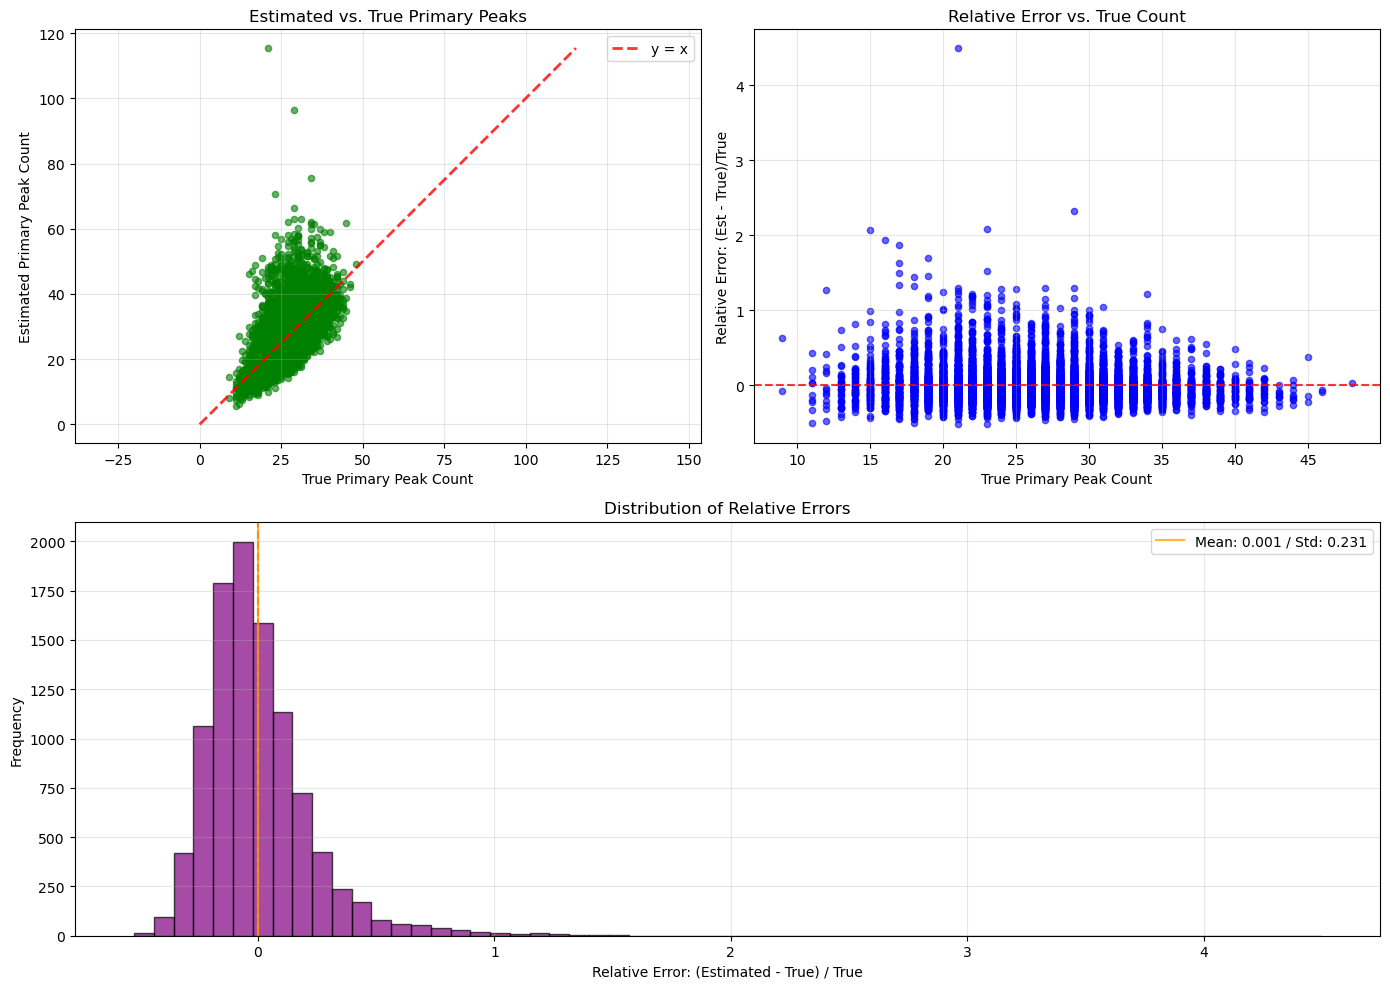

Correlation: 0.640
Mean difference (estimated - true): -0.10
Standard deviation of differences: 5.83
Mean relative error: 0.001
Std relative error: 0.231
Median relative error: -0.038
Events with zero true peaks excluded: 10000 / 10000


In [11]:
T1 = 3 * np.std(data['wf_i'][1][2500:2900])
T2 = 0.053320

testdata = {key: data[key][1000:11000] for key in data.keys()}
true_peak_counts = np.count_nonzero(testdata['tag_values'], axis=1)
true_primary_peak_counts = np.sum(testdata['tag_values'] == 1, axis=1)

detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
detected_peak_counts = [len(peaks) for peaks in detected_peaks]

primary_counts_fixed = estimate_primary_from_cluster_window(detected_peaks, b=24, c=1.60, d=2)

primary_counts_fixed = np.array(primary_counts_fixed)
true_primary_peak_counts = np.array(true_primary_peak_counts)

mask = true_primary_peak_counts > 0
relative_error = (primary_counts_fixed[mask] - true_primary_peak_counts[mask]) / true_primary_peak_counts[mask]
diff = primary_counts_fixed - true_primary_peak_counts
correlation = np.corrcoef(true_primary_peak_counts, primary_counts_fixed)[0, 1]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.scatter(true_primary_peak_counts, primary_counts_fixed, alpha=0.6, s=20, color='green')
max_val = max(np.max(true_primary_peak_counts), np.max(primary_counts_fixed))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y = x')
plt.xlabel('True Primary Peak Count')
plt.ylabel('Estimated Primary Peak Count')
plt.title('Estimated vs. True Primary Peaks')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(true_primary_peak_counts[mask], relative_error, alpha=0.6, s=20, color='blue')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Primary Peak Count')
plt.ylabel('Relative Error: (Est - True)/True')
plt.title('Relative Error vs. True Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=60, alpha=0.7, edgecolor='black', color='purple')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8,
            label=f'Mean: {np.mean(relative_error):.3f} / Std: {np.std(relative_error):.3f}')
plt.xlabel('Relative Error: (Estimated - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Correlation: {correlation:.3f}")
print(f"Mean difference (estimated - true): {np.mean(diff):.2f}")
print(f"Standard deviation of differences: {np.std(diff):.2f}")
print(f"Mean relative error: {np.mean(relative_error):.3f}")
print(f"Std relative error: {np.std(relative_error):.3f}")
print(f"Median relative error: {np.median(relative_error):.3f}")
print(f"Events with zero true peaks excluded: {np.sum(mask)} / {len(true_primary_peak_counts)}")

Processing waveforms: 100%|██████████| 2000/2000 [00:04<00:00, 495.74waveform/s]


Extracting true primary peaks from labels (vectorized)...


Processing waveforms: 100%|██████████| 2000/2000 [00:00<00:00, 624198.82waveform/s]


Starting adaptive parameter scanning...
Scanning parameters for region r1 (0-130)


Region r1: 100%|██████████| 5940/5940 [00:02<00:00, 2484.49it/s]


Best params for r1: {'b': 8, 'c': 0.8, 'd': 2}, Score: 0.0016
Scanning parameters for region r2 (130-400)


Region r2: 100%|██████████| 5940/5940 [00:32<00:00, 185.51it/s]


Best params for r2: {'b': 32, 'c': 1.0, 'd': 5}, Score: 0.0003
Scanning parameters for region r3 (400-1550)


Region r3: 100%|██████████| 5940/5940 [01:47<00:00, 55.45it/s]


Best params for r3: {'b': 67, 'c': 1.4, 'd': 2}, Score: 0.0000
Scanning parameters for region r4 (1550-3000)


Region r4: 100%|██████████| 5940/5940 [00:15<00:00, 390.84it/s]


Best params for r4: {'b': 99, 'c': 0.8, 'd': 1}, Score: 0.2015

Performance comparison:
Adaptive method MAE: 3.3894
Fixed parameter method MAE: 4.1976
Improvement: 19.25%


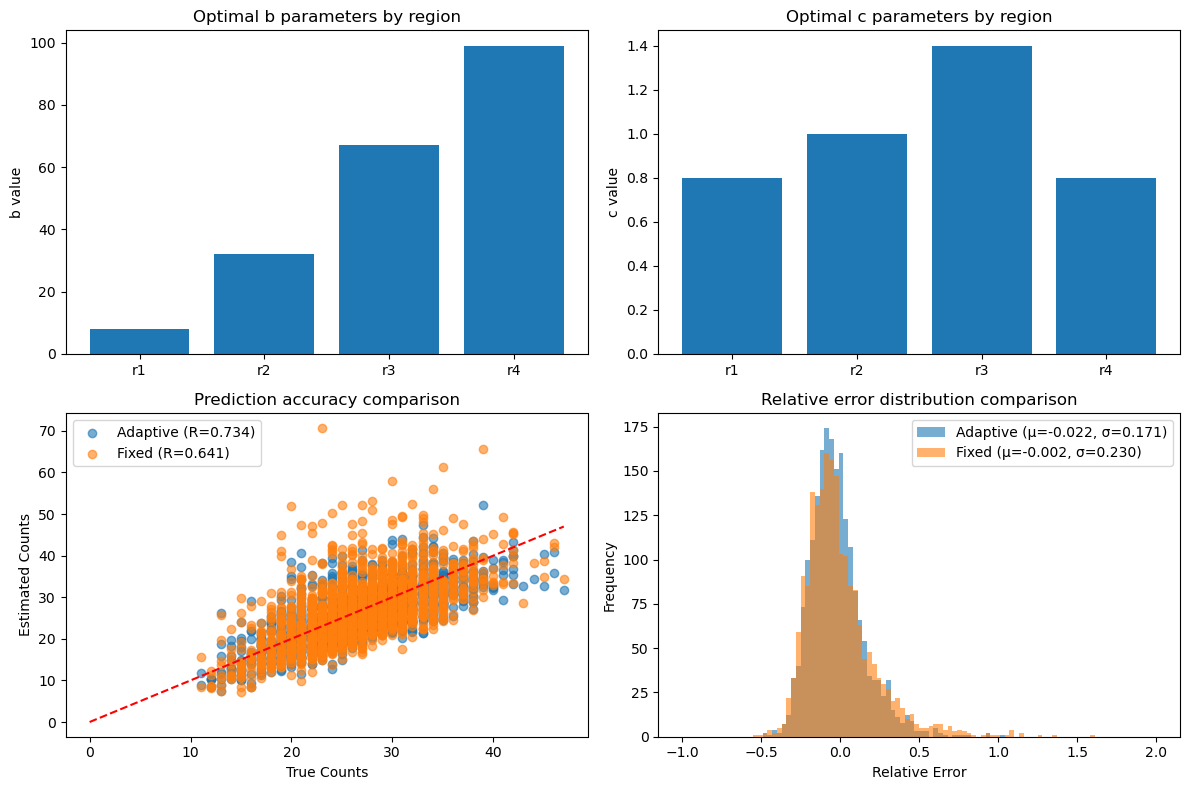

In [19]:
testdata = {key: data[key][:2000] for key in data.keys()}
detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
detected_peak_counts = [len(peaks) for peaks in detected_peaks]

true_primary_peaks = extract_true_primary_peaks_from_labels(testdata)

# Run complete workflow
results = run_adaptive_parameter_optimization(detected_peaks, true_primary_peaks)

<span style="font-size:24px">*Clusterization Method tested on truth-level peask info*</span>

In [21]:
testdata = {key: data[key][:2000] for key in data.keys()}
true_peaks = extract_true_peaks_from_labels(testdata)

true_primary_peak_counts = np.sum(testdata['tag_values'] == 1, axis=1)
true_primary_peak_counts = np.array(true_primary_peak_counts)

print(f"Total waveforms processed: {len(true_peaks)}")
print(f"Example - First waveform true peaks: {true_peaks[0][:10]}...")
print(f"Example - Number of true peaks in first 5 waveforms: {[len(peaks) for peaks in true_peaks[:5]]}")

Extracting true peaks from labels (vectorized)...


Processing waveforms: 100%|██████████| 2000/2000 [00:00<00:00, 268702.01waveform/s]

Total waveforms processed: 2000
Example - First waveform true peaks: [139, 140, 173, 175, 184, 290, 296, 300, 303, 361]...
Example - Number of true peaks in first 5 waveforms: [32, 61, 30, 20, 41]


In [21]:
b_values = np.arange(1, 100, 1)
c_values = np.arange(0.5, 3.0, 0.1)
d_values = np.arange(1, 6, 1)


mean_diff_map = np.zeros((len(b_values), len(c_values), len(d_values)))
std_diff_map = np.zeros((len(b_values), len(c_values), len(d_values)))

mean_diff_map_abs = np.zeros((len(b_values), len(c_values), len(d_values)))
std_diff_map_abs = np.zeros((len(b_values), len(c_values), len(d_values)))

for i, b in enumerate(tqdm(b_values, desc="Scanning b")):
    for j, c in enumerate(c_values):
        for k, d in enumerate(d_values):
            primary_counts_est = estimate_primary_from_cluster_window(true_peaks, b=b, c=c, d=d)
            primary_counts_est = np.array(primary_counts_est)

            abs_diff = primary_counts_est - true_primary_peak_counts
            mean_diff_map_abs[i, j, k] = np.mean(abs_diff)
            std_diff_map_abs[i, j, k] = np.std(abs_diff)

            with np.errstate(divide='ignore', invalid='ignore'):
                relative_errors = np.true_divide(
                    primary_counts_est - true_primary_peak_counts,
                    true_primary_peak_counts
                )
                relative_errors[~np.isfinite(relative_errors)] = np.nan

            valid_errors = relative_errors[~np.isnan(relative_errors)]
            mean_diff_map[i, j, k] = np.mean(valid_errors)
            std_diff_map[i, j, k] = np.std(valid_errors)

Scanning b: 100%|██████████| 99/99 [07:00<00:00,  4.25s/it]


Best mean ~0 at b=69, c=0.8999999999999999, d=3 → mean = -0.0000, std = 0.1387
Best std min at b=99, c=0.5, d=1 → mean = -0.5818, std = 0.0779


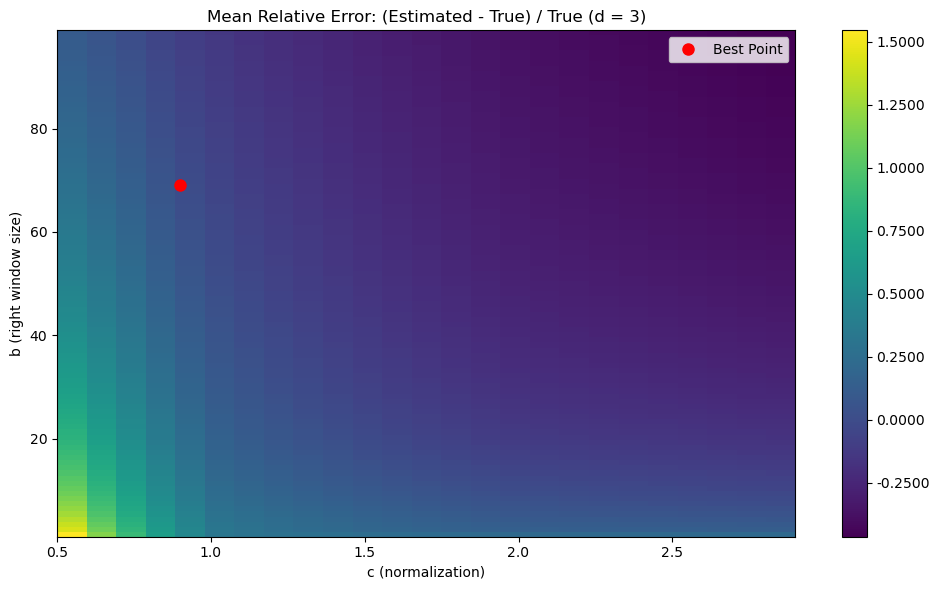

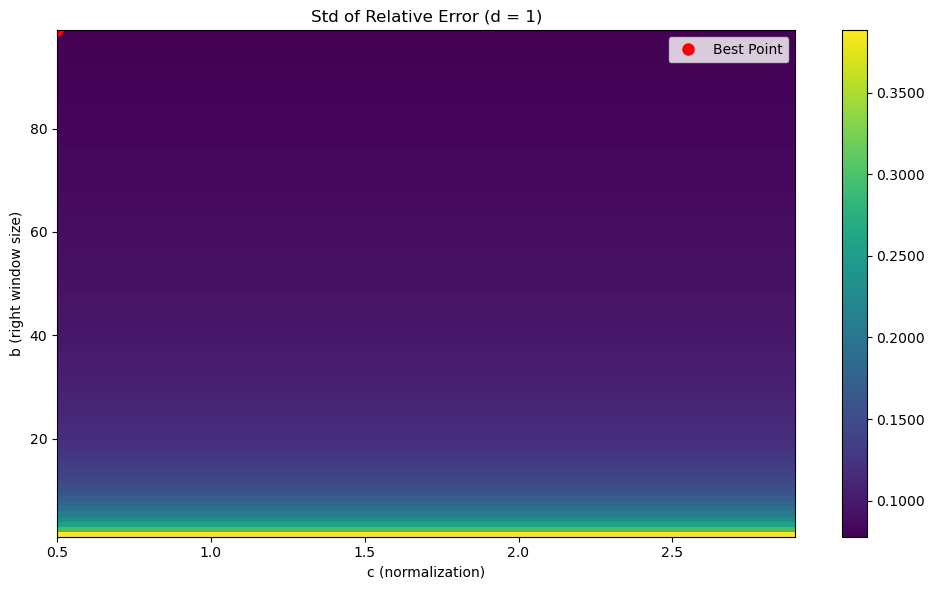

In [ ]:
#Best parameters for fixed clusterization method

best_mean_idx = find_best_indices_3d(mean_diff_map, mode="mean")
best_std_idx = find_best_indices_3d(std_diff_map, mode="std")

best_mean_val = mean_diff_map[best_mean_idx]
best_std_val_at_mean = std_diff_map[best_mean_idx]
best_std_val = std_diff_map[best_std_idx]
best_mean_val_at_std = mean_diff_map[best_std_idx]

print(f"Best mean ~0 at b={b_values[best_mean_idx[0]]}, c={c_values[best_mean_idx[1]]}, d={d_values[best_mean_idx[2]]} "
      f"→ mean = {best_mean_val:.4f}, std = {best_std_val_at_mean:.4f}")

print(f"Best std min at b={b_values[best_std_idx[0]]}, c={c_values[best_std_idx[1]]}, d={d_values[best_std_idx[2]]} "
      f"→ mean = {best_mean_val_at_std:.4f}, std = {best_std_val:.4f}")

plot_heatmap_2d_slice(mean_diff_map, d_idx=best_mean_idx[2],
                      title="Mean Relative Error: (Estimated - True) / True",
                      x_labels=c_values, y_labels=b_values,
                      x_name="c (normalization)", y_name="b (right window size)",
                      highlight=best_mean_idx)

plot_heatmap_2d_slice(std_diff_map, d_idx=best_std_idx[2],
                      title="Std of Relative Error",
                      x_labels=c_values, y_labels=b_values,
                      x_name="c (normalization)", y_name="b (right window size)",
                      highlight=best_std_idx)

Extracting true peaks from labels (vectorized)...


Processing waveforms: 100%|██████████| 12000/12000 [00:00<00:00, 326379.58waveform/s]


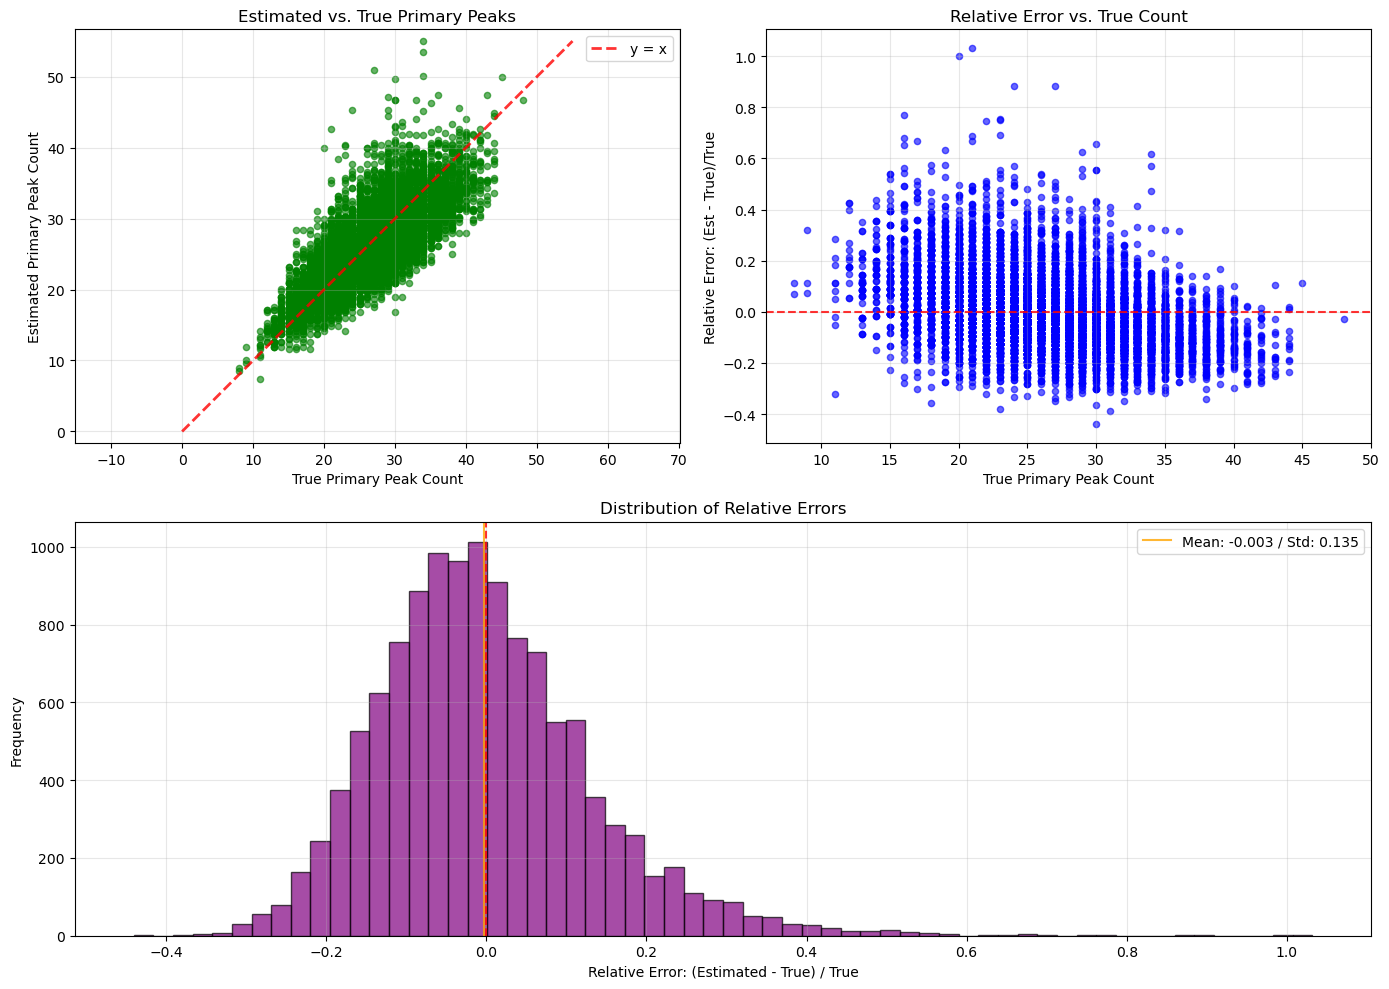

Correlation: 0.786
Mean difference (estimated - true): -0.37
Standard deviation of differences: 3.49
Mean relative error: -0.003
Std relative error: 0.135
Median relative error: -0.017
Events with zero true peaks excluded: 12000 / 12000


In [8]:
more_testdata = {key: data[key][2000:14000] for key in data.keys()}
more_true_peaks = extract_true_peaks_from_labels(more_testdata)

true_primary_peak_counts = np.sum(more_testdata['tag_values'] == 1, axis=1)
true_primary_peak_counts = np.array(true_primary_peak_counts)


primary_counts_fixed = estimate_primary_from_cluster_window(more_true_peaks, b=69, c=0.8999, d=3)
true_primary_peak_counts = np.sum(more_testdata['tag_values'] == 1, axis=1)

primary_counts_fixed = np.array(primary_counts_fixed)
true_primary_peak_counts = np.array(true_primary_peak_counts)

mask = true_primary_peak_counts > 0
relative_error = (primary_counts_fixed[mask] - true_primary_peak_counts[mask]) / true_primary_peak_counts[mask]
diff = primary_counts_fixed - true_primary_peak_counts
correlation = np.corrcoef(true_primary_peak_counts, primary_counts_fixed)[0, 1]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.scatter(true_primary_peak_counts, primary_counts_fixed, alpha=0.6, s=20, color='green')
max_val = max(np.max(true_primary_peak_counts), np.max(primary_counts_fixed))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y = x')
plt.xlabel('True Primary Peak Count')
plt.ylabel('Estimated Primary Peak Count')
plt.title('Estimated vs. True Primary Peaks')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(true_primary_peak_counts[mask], relative_error, alpha=0.6, s=20, color='blue')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Primary Peak Count')
plt.ylabel('Relative Error: (Est - True)/True')
plt.title('Relative Error vs. True Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=60, alpha=0.7, edgecolor='black', color='purple')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8,
            label=f'Mean: {np.mean(relative_error):.3f} / Std: {np.std(relative_error):.3f}')
plt.xlabel('Relative Error: (Estimated - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Correlation: {correlation:.3f}")
print(f"Mean difference (estimated - true): {np.mean(diff):.2f}")
print(f"Standard deviation of differences: {np.std(diff):.2f}")
print(f"Mean relative error: {np.mean(relative_error):.3f}")
print(f"Std relative error: {np.std(relative_error):.3f}")
print(f"Median relative error: {np.median(relative_error):.3f}")
print(f"Events with zero true peaks excluded: {np.sum(mask)} / {len(true_primary_peak_counts)}")

Extracting true primary peaks from labels (vectorized)...


Processing waveforms: 100%|██████████| 2000/2000 [00:00<00:00, 384181.73waveform/s]


Starting adaptive parameter scanning...
Scanning parameters for region r1 (0-130)


Region r1: 100%|██████████| 5940/5940 [00:04<00:00, 1418.52it/s]


Best params for r1: {'b': 13, 'c': 1.4, 'd': 3}, Score: 0.0001
Scanning parameters for region r2 (130-400)


Region r2: 100%|██████████| 5940/5940 [00:38<00:00, 153.26it/s]


Best params for r2: {'b': 43, 'c': 0.8, 'd': 3}, Score: 0.0001
Scanning parameters for region r3 (400-1550)


Region r3: 100%|██████████| 5940/5940 [01:28<00:00, 67.26it/s]


Best params for r3: {'b': 84, 'c': 1.2, 'd': 4}, Score: 0.0000
Scanning parameters for region r4 (1550-3000)


Region r4: 100%|██████████| 5940/5940 [00:11<00:00, 506.76it/s]


Best params for r4: {'b': 80, 'c': 0.8, 'd': 1}, Score: 0.0009

Performance comparison:
Adaptive method MAE: 2.3869
Fixed parameter method MAE: 2.7131
Improvement: 12.02%


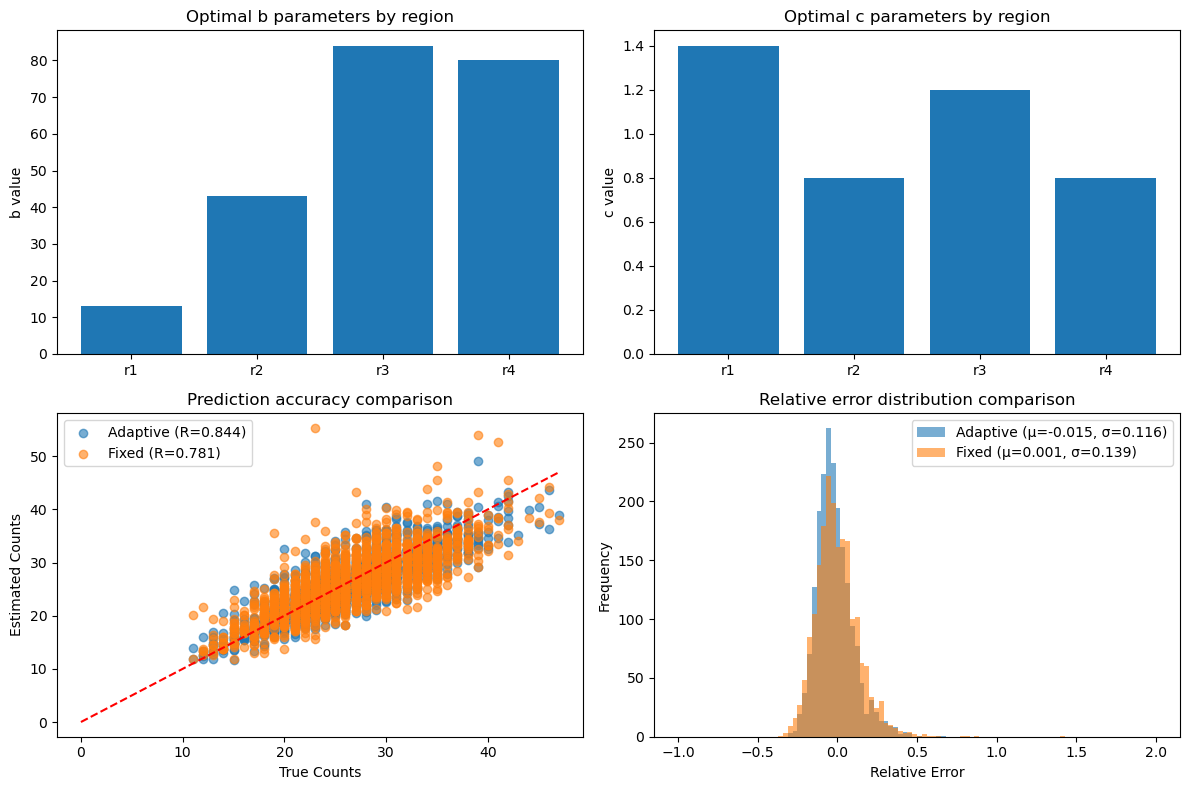

In [22]:
true_primary_peaks = extract_true_primary_peaks_from_labels(testdata)
results = run_adaptive_parameter_optimization(true_peaks, true_primary_peaks)

<span style="font-size:24px">*Clusterization Method tested in high-count region*</span>

In [ ]:
# Fixed Clusterization Method
T1 = 3 * np.std(data['wf_i'][1][2500:2900])
T2 = 0.053320

testdata = {key: data[key][10000:30000] for key in data.keys()}
high_count_mask = (testdata['tag_values'] == 1) & (testdata['tag_times'] >= 150) & (testdata['tag_times'] < 1500)
true_primary_peak_counts = np.sum(high_count_mask, axis=1)
true_primary_peak_counts = np.array(true_primary_peak_counts)

detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
primary_counts_fixed = collect_cluster_peaks(detected_peaks, 14, 1.99, 2)

primary_counts_fixed = [
    [peak for cluster in waveform_clusters for peak in cluster if 150 <= peak < 1500]
    for waveform_clusters in primary_counts_fixed
]

primary_counts_fixed_counts = [len(peaks) for peaks in primary_counts_fixed]
primary_counts_fixed_counts = np.array(primary_counts_fixed_counts)

mask = true_primary_peak_counts > 0
relative_error = (primary_counts_fixed_counts[mask] - true_primary_peak_counts[mask]) / true_primary_peak_counts[mask]
diff = primary_counts_fixed_counts - true_primary_peak_counts
correlation = np.corrcoef(true_primary_peak_counts, primary_counts_fixed_counts)[0, 1]

Processing waveforms: 100%|██████████| 50000/50000 [01:41<00:00, 491.12waveform/s]


Processing time windows...
Processing window [0-200)


Processing waveforms: 100%|██████████| 20000/20000 [00:39<00:00, 501.42waveform/s]


Processing window [200-400)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 494.58waveform/s]


Processing window [400-600)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 490.82waveform/s]


Processing window [600-800)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 487.18waveform/s]


Processing window [800-1000)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 486.11waveform/s]


Processing window [1000-1200)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 488.97waveform/s]


Processing window [1200-1400)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 490.07waveform/s]


Processing window [1400-1600)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 492.80waveform/s]


Processing window [1600-1800)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 492.38waveform/s]


Processing window [1800-2000)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 489.91waveform/s]


Processing window [2000-2200)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 491.35waveform/s]


Processing window [2200-2400)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 489.85waveform/s]


Processing window [2400-2600)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 492.32waveform/s]


Processing window [2600-2800)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 491.89waveform/s]


Processing window [2800-3000)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 490.33waveform/s]


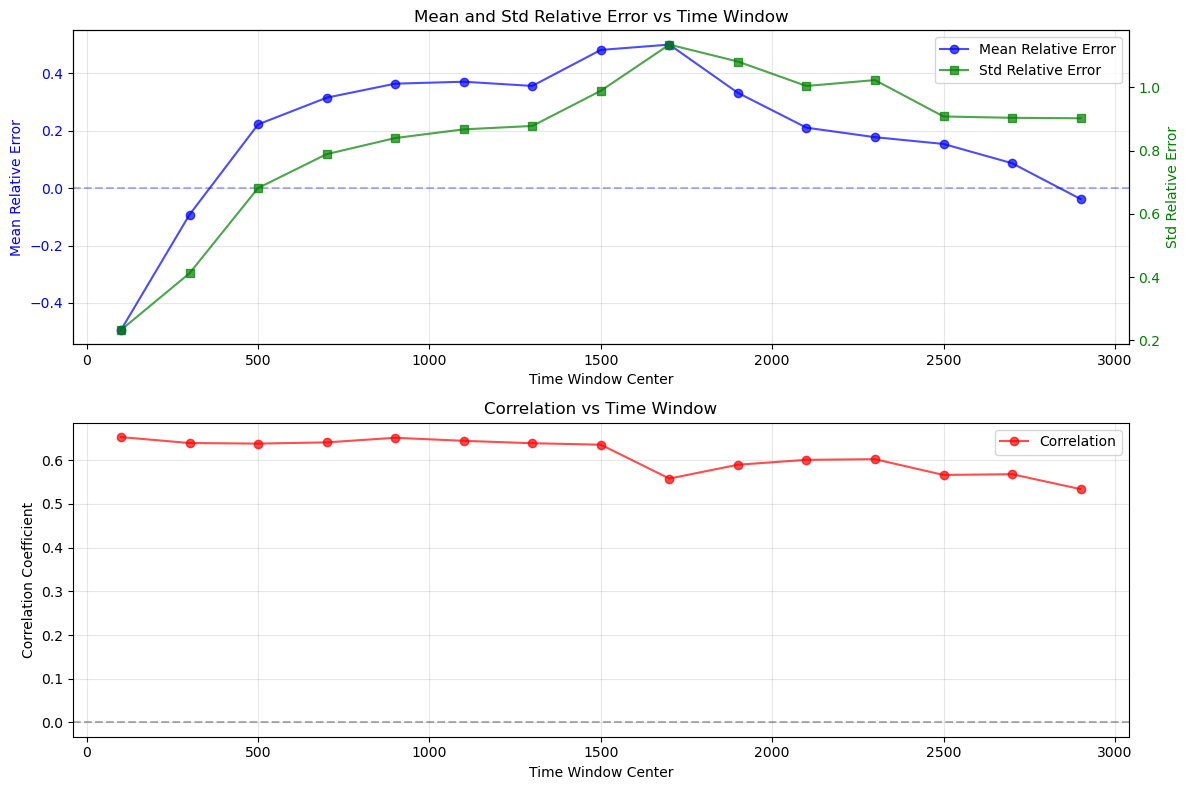


=== Summary ===
Mean relative error: 0.1962
Mean std relative error: 0.8433
Mean correlation: 0.6108
Valid windows: 15/15


In [8]:
# Scan the whole time range
T1 = 3 * np.std(data['wf_i'][1][2500:2900])
T2 = 0.053320

testdata = {key: data[key][10000:30000] for key in data.keys()}

# Define time windows and initialize results
window_size = 200
time_windows = [(i, i + window_size) for i in range(0, 3000, window_size)]
window_centers = []
mean_relative_errors = []
std_relative_errors = []
correlations = []

print("Processing time windows...")

# Process each time window
for start, end in time_windows:
    print(f"Processing window [{start}-{end})")
    window_centers.append((start + end) / 2)
    
    # Calculate true and predicted counts for this window
    window_mask = (testdata['tag_values'] == 1) & (testdata['tag_times'] >= start) & (testdata['tag_times'] < end)
    true_counts_window = np.sum(window_mask, axis=1)
    
    detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
    primary_counts_fixed = collect_cluster_peaks(detected_peaks, 14, 1.99, 2)
    
    primary_counts_fixed_window = [
        [peak for cluster in waveform_clusters for peak in cluster if start <= peak < end]
        for waveform_clusters in primary_counts_fixed
    ]
    predicted_counts = np.array([len(peaks) for peaks in primary_counts_fixed_window])
    
    # Calculate metrics for valid samples (true_counts > 0)
    mask = true_counts_window > 0
    if np.sum(mask) > 0:
        relative_error = (predicted_counts[mask] - true_counts_window[mask]) / true_counts_window[mask]
        mean_relative_errors.append(np.mean(relative_error))
        std_relative_errors.append(np.std(relative_error))
        
        # Calculate correlation
        if len(np.unique(true_counts_window)) > 1 and len(np.unique(predicted_counts)) > 1:
            correlations.append(np.corrcoef(true_counts_window, predicted_counts)[0, 1])
        else:
            correlations.append(0.0)
    else:
        mean_relative_errors.append(np.nan)
        std_relative_errors.append(np.nan)
        correlations.append(np.nan)

# Convert to numpy arrays
window_centers = np.array(window_centers)
mean_relative_errors = np.array(mean_relative_errors)
std_relative_errors = np.array(std_relative_errors)
correlations = np.array(correlations)

# Create visualization with dual y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Mean and Std Relative Error (dual y-axis)
valid_mask = ~np.isnan(mean_relative_errors)
ax1_twin = ax1.twinx()

line1 = ax1.plot(window_centers[valid_mask], mean_relative_errors[valid_mask], 
                 'o-b', alpha=0.7, label='Mean Relative Error')
ax1.set_xlabel('Time Window Center')
ax1.set_ylabel('Mean Relative Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axhline(y=0, color='blue', linestyle='--', alpha=0.3)

valid_mask_std = ~np.isnan(std_relative_errors)
line2 = ax1_twin.plot(window_centers[valid_mask_std], std_relative_errors[valid_mask_std], 
                      's-g', alpha=0.7, label='Std Relative Error')
ax1_twin.set_ylabel('Std Relative Error', color='green')
ax1_twin.tick_params(axis='y', labelcolor='green')

ax1.set_title('Mean and Std Relative Error vs Time Window')
ax1.grid(True, alpha=0.3)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Plot 2: Correlation
valid_mask_corr = ~np.isnan(correlations)
ax2.plot(window_centers[valid_mask_corr], correlations[valid_mask_corr], 
         'o-r', alpha=0.7, label='Correlation')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time Window Center')
ax2.set_ylabel('Correlation Coefficient')
ax2.set_title('Correlation vs Time Window')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== Summary ===")
print(f"Mean relative error: {np.nanmean(mean_relative_errors):.4f}")
print(f"Mean std relative error: {np.nanmean(std_relative_errors):.4f}")
print(f"Mean correlation: {np.nanmean(correlations):.4f}")
print(f"Valid windows: {np.sum(~np.isnan(mean_relative_errors))}/{len(time_windows)}")

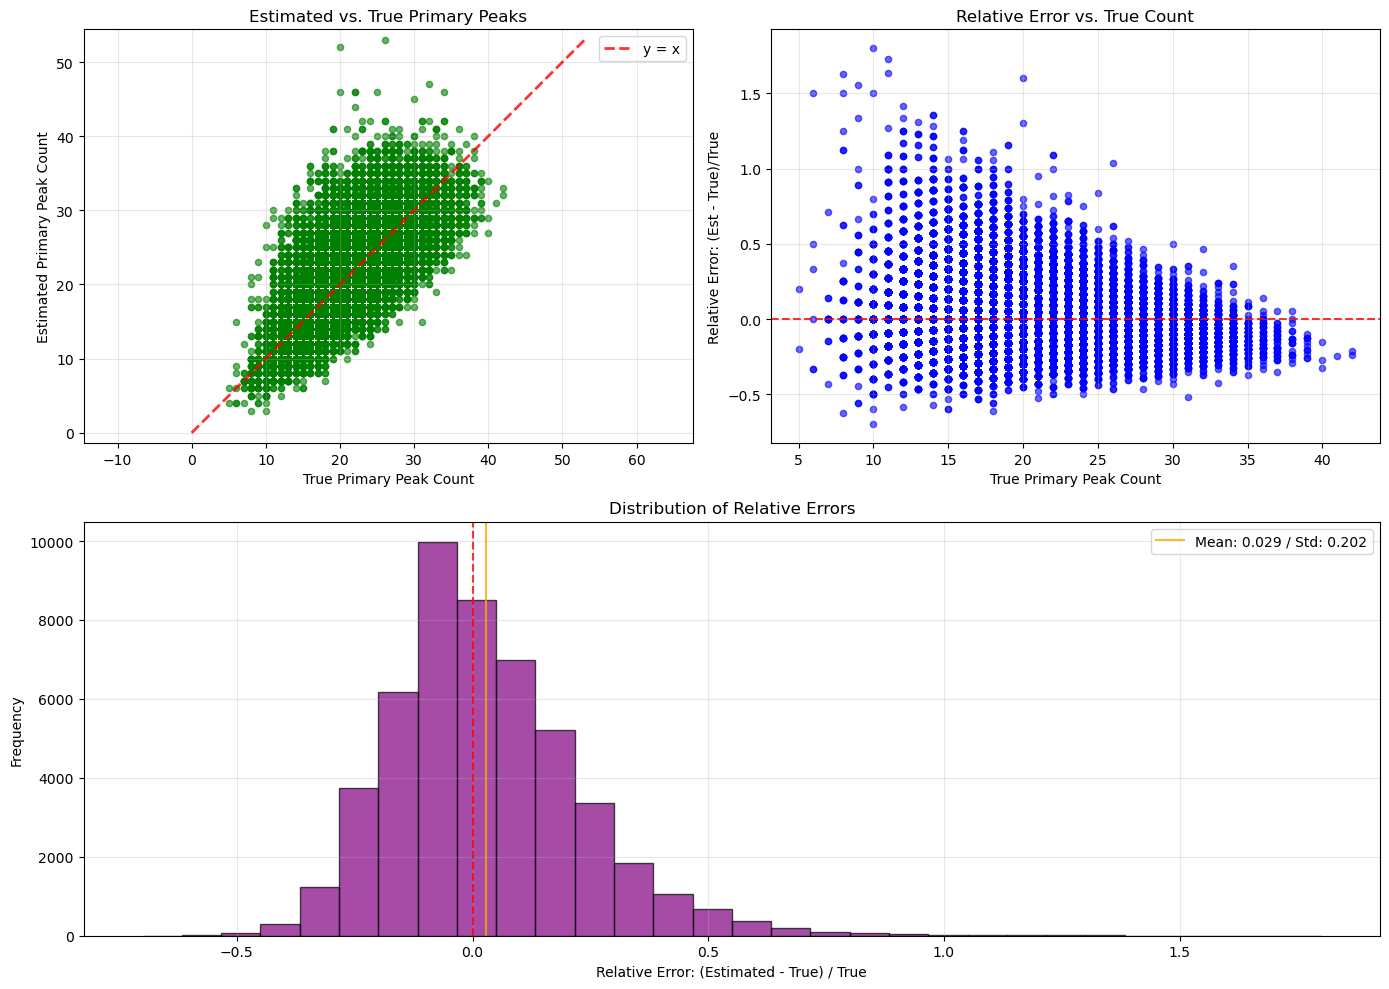

Correlation: 0.704
Mean difference (estimated - true): 0.42
Standard deviation of differences: 3.99
Mean relative error: 0.029
Std relative error: 0.202
Median relative error: 0.000
Events with zero true peaks excluded: 50000 / 50000


In [45]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.scatter(true_primary_peak_counts, primary_counts_fixed_counts, alpha=0.6, s=20, color='green')
max_val = max(np.max(true_primary_peak_counts), np.max(primary_counts_fixed_counts))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y = x')
plt.xlabel('True Primary Peak Count')
plt.ylabel('Estimated Primary Peak Count')
plt.title('Estimated vs. True Primary Peaks')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(true_primary_peak_counts[mask], relative_error, alpha=0.6, s=20, color='blue')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Primary Peak Count')
plt.ylabel('Relative Error: (Est - True)/True')
plt.title('Relative Error vs. True Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=30, alpha=0.7, edgecolor='black', color='purple')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8,
            label=f'Mean: {np.mean(relative_error):.3f} / Std: {np.std(relative_error):.3f}')
plt.xlabel('Relative Error: (Estimated - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Correlation: {correlation:.3f}")
print(f"Mean difference (estimated - true): {np.mean(diff):.2f}")
print(f"Standard deviation of differences: {np.std(diff):.2f}")
print(f"Mean relative error: {np.mean(relative_error):.3f}")
print(f"Std relative error: {np.std(relative_error):.3f}")
print(f"Median relative error: {np.median(relative_error):.3f}")
print(f"Events with zero true peaks excluded: {np.sum(mask)} / {len(true_primary_peak_counts)}")

In [48]:
# Adaptive Clusterization Method
T1 = 3 * np.std(data['wf_i'][1][2500:2900])
T2 = 0.053320

best_params = {
    'r1': {'b': 8, 'c': 0.8, 'd': 2},
    'r2': {'b': 32, 'c': 1.0, 'd': 5},
    'r3': {'b': 67, 'c': 1.4, 'd': 2},
    'r4': {'b': 99, 'c': 0.8, 'd': 1}
}

b_map = {region: params['b'] for region, params in best_params.items()}
c_map = {region: params['c'] for region, params in best_params.items()}
d_map = {region: params['d'] for region, params in best_params.items()}

print("Parameter mappings:")
print(f"b_map: {b_map}")
print(f"c_map: {c_map}")
print(f"d_map: {d_map}")

region_bounds = {
    'r1': (0, 130),
    'r2': (130, 400),
    'r3': (400, 1550),
    'r4': (1550, 3000),
}

testdata = {key: data[key][:50000] for key in data.keys()}
high_count_mask = (testdata['tag_values'] == 1) & (testdata['tag_times'] >= 150) & (testdata['tag_times'] < 500)
true_primary_peak_counts = np.sum(high_count_mask, axis=1)
true_primary_peak_counts = np.array(true_primary_peak_counts)

detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)

primary_counts_adaptive = collect_cluster_peaks_adaptive(detected_peaks, b_map, c_map, d_map)

primary_counts_adaptive_flattened = [
    [peak for cluster in waveform_clusters for peak in cluster if 150 <= peak < 500]
    for waveform_clusters in primary_counts_adaptive
]

primary_counts_adaptive_counts = np.array([len(peaks) for peaks in primary_counts_adaptive_flattened])
primary_counts_adaptive_counts = np.array(primary_counts_adaptive_counts)

mask = true_primary_peak_counts > 0
relative_error = (primary_counts_adaptive_counts[mask] - true_primary_peak_counts[mask]) / true_primary_peak_counts[mask]
diff = primary_counts_adaptive_counts - true_primary_peak_counts
correlation = np.corrcoef(true_primary_peak_counts, primary_counts_adaptive_counts)[0, 1]

Parameter mappings:
b_map: {'r1': 8, 'r2': 32, 'r3': 67, 'r4': 99}
c_map: {'r1': 0.8, 'r2': 1.0, 'r3': 1.4, 'r4': 0.8}
d_map: {'r1': 2, 'r2': 5, 'r3': 2, 'r4': 1}


Processing waveforms: 100%|██████████| 50000/50000 [01:41<00:00, 490.62waveform/s]


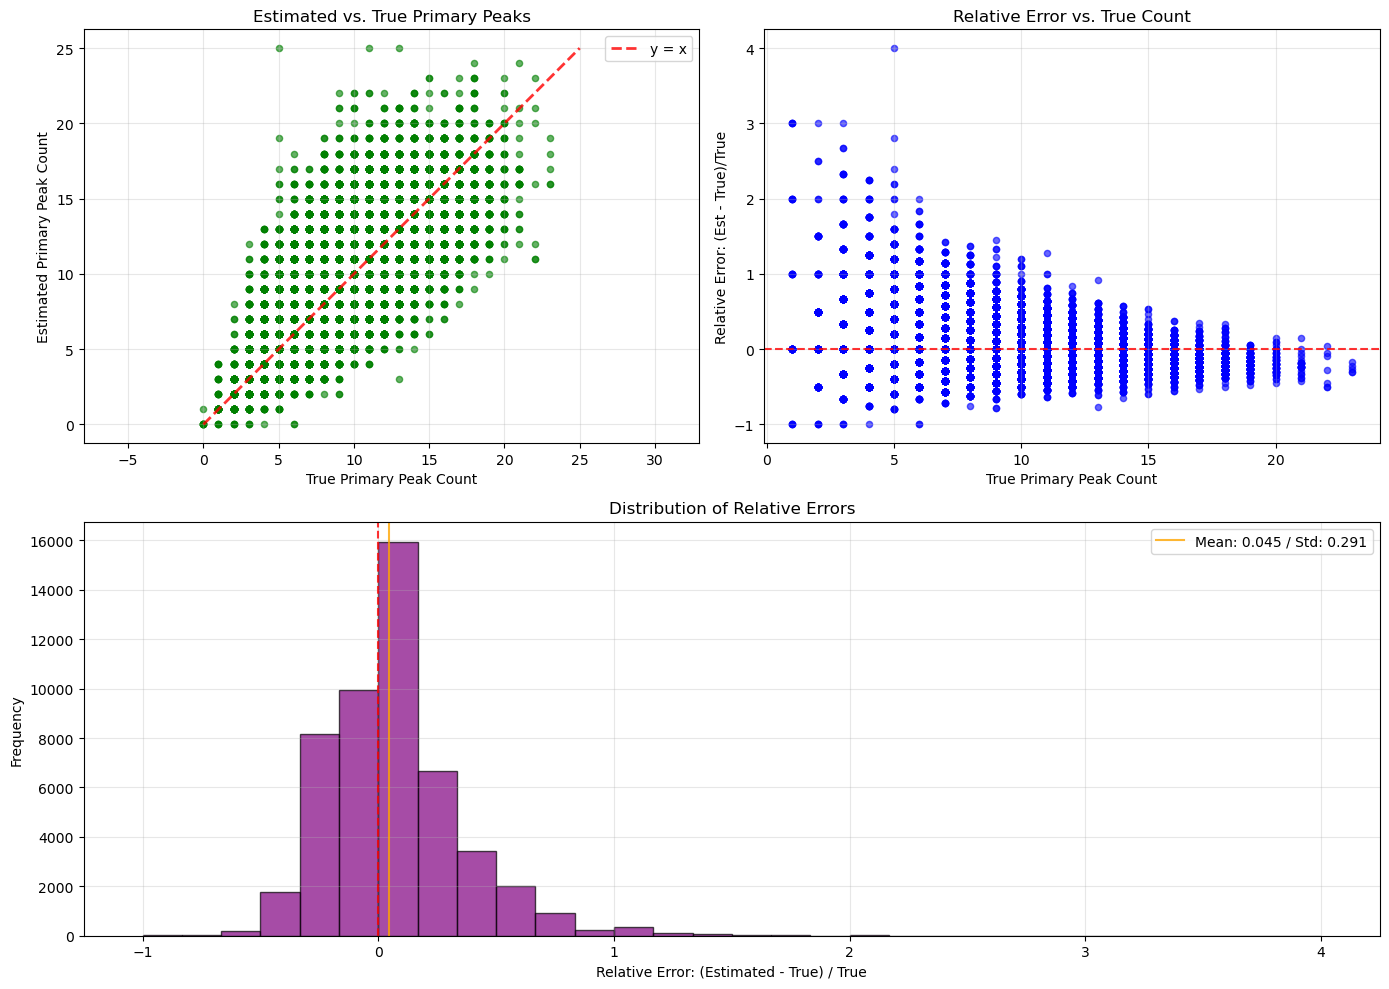

Correlation: 0.718
Mean difference (estimated - true): 0.14
Standard deviation of differences: 2.37
Mean relative error: 0.045
Std relative error: 0.291
Median relative error: 0.000
Events with zero true peaks excluded: 49991 / 50000


In [49]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.scatter(true_primary_peak_counts, primary_counts_adaptive_counts, alpha=0.6, s=20, color='green')
max_val = max(np.max(true_primary_peak_counts), np.max(primary_counts_adaptive_counts))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y = x')
plt.xlabel('True Primary Peak Count')
plt.ylabel('Estimated Primary Peak Count')
plt.title('Estimated vs. True Primary Peaks')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(true_primary_peak_counts[mask], relative_error, alpha=0.6, s=20, color='blue')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Primary Peak Count')
plt.ylabel('Relative Error: (Est - True)/True')
plt.title('Relative Error vs. True Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=30, alpha=0.7, edgecolor='black', color='purple')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8,
            label=f'Mean: {np.mean(relative_error):.3f} / Std: {np.std(relative_error):.3f}')
plt.xlabel('Relative Error: (Estimated - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Correlation: {correlation:.3f}")
print(f"Mean difference (estimated - true): {np.mean(diff):.2f}")
print(f"Standard deviation of differences: {np.std(diff):.2f}")
print(f"Mean relative error: {np.mean(relative_error):.3f}")
print(f"Std relative error: {np.std(relative_error):.3f}")
print(f"Median relative error: {np.median(relative_error):.3f}")
print(f"Events with zero true peaks excluded: {np.sum(mask)} / {len(true_primary_peak_counts)}")

Processing adaptive method for time windows...
Processing adaptive window [0-200)


Processing waveforms:   0%|          | 0/20000 [00:00<?, ?waveform/s]

Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 495.77waveform/s]


Processing adaptive window [200-400)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 488.08waveform/s]


Processing adaptive window [400-600)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 485.90waveform/s]


Processing adaptive window [600-800)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 485.19waveform/s]


Processing adaptive window [800-1000)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 485.57waveform/s]


Processing adaptive window [1000-1200)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 484.44waveform/s]


Processing adaptive window [1200-1400)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 484.64waveform/s]


Processing adaptive window [1400-1600)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 484.73waveform/s]


Processing adaptive window [1600-1800)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 484.51waveform/s]


Processing adaptive window [1800-2000)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 484.79waveform/s]


Processing adaptive window [2000-2200)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 483.90waveform/s]


Processing adaptive window [2200-2400)


Processing waveforms: 100%|██████████| 20000/20000 [00:41<00:00, 483.36waveform/s]


Processing adaptive window [2400-2600)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 487.85waveform/s]


Processing adaptive window [2600-2800)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 488.23waveform/s]


Processing adaptive window [2800-3000)


Processing waveforms: 100%|██████████| 20000/20000 [00:40<00:00, 488.61waveform/s]


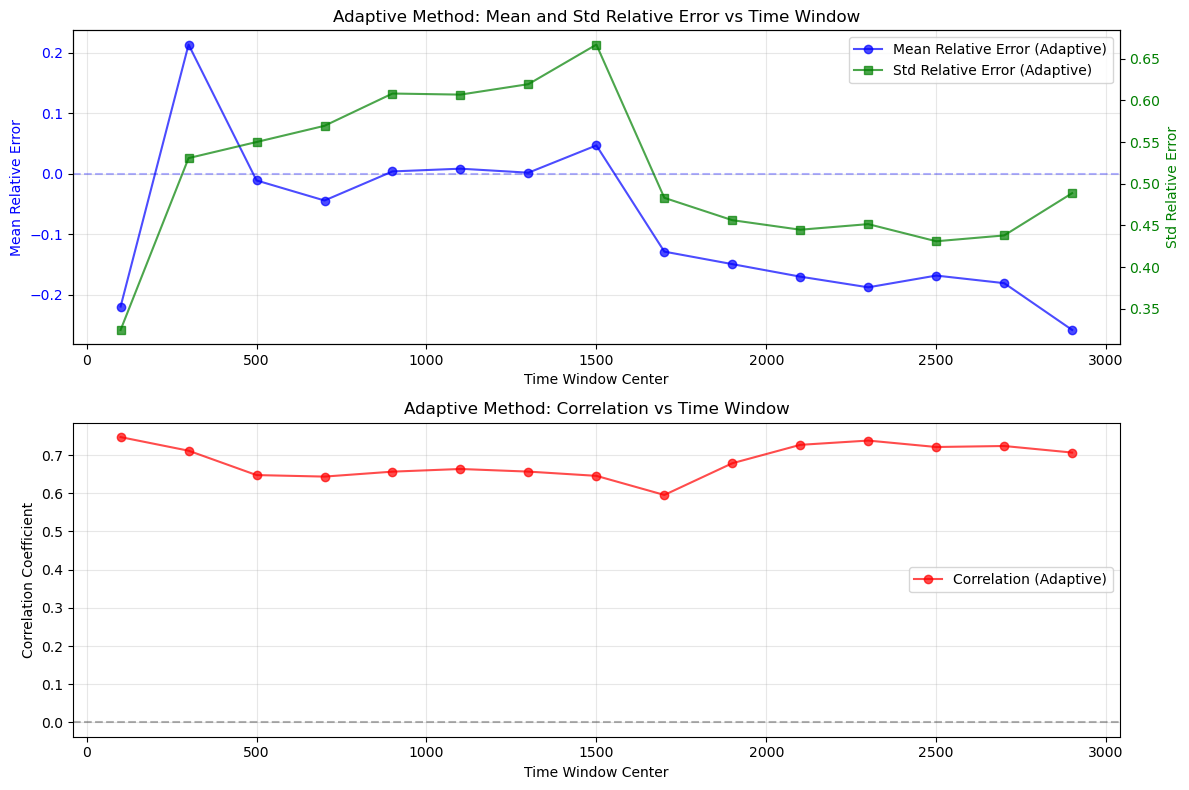


=== Adaptive Method Summary ===
Mean relative error: -0.0831
Mean std relative error: 0.5114
Mean correlation: 0.6841
Valid windows: 15/15


In [7]:
# Adaptive Clusterization Method - Full Time Range Scan
T1 = 3 * np.std(data['wf_i'][1][2500:2900])
T2 = 0.053320

best_params = {
    'r1': {'b': 8, 'c': 0.8, 'd': 2},
    'r2': {'b': 32, 'c': 1.0, 'd': 5},
    'r3': {'b': 67, 'c': 1.4, 'd': 2},
    'r4': {'b': 99, 'c': 0.8, 'd': 1}
}

b_map = {region: params['b'] for region, params in best_params.items()}
c_map = {region: params['c'] for region, params in best_params.items()}
d_map = {region: params['d'] for region, params in best_params.items()}

region_bounds = {
    'r1': (0, 130),
    'r2': (130, 400),
    'r3': (400, 1550),
    'r4': (1550, 3000),
}

testdata = {key: data[key][10000:30000] for key in data.keys()}

# Define time windows and initialize results
window_size = 200
time_windows = [(i, i + window_size) for i in range(0, 3000, window_size)]
window_centers_adaptive = []
mean_relative_errors_adaptive = []
std_relative_errors_adaptive = []
correlations_adaptive = []

print("Processing adaptive method for time windows...")

# Process each time window
for start, end in time_windows:
    print(f"Processing adaptive window [{start}-{end})")
    window_centers_adaptive.append((start + end) / 2)
    
    # Calculate true counts for this window
    window_mask = (testdata['tag_values'] == 1) & (testdata['tag_times'] >= start) & (testdata['tag_times'] < end)
    true_counts_window = np.sum(window_mask, axis=1)
    
    # Get detected peaks and apply adaptive clustering
    detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
    primary_counts_adaptive = collect_cluster_peaks_adaptive(detected_peaks, b_map, c_map, d_map)
    
    # Filter adaptive results for this window
    primary_counts_adaptive_window = [
        [peak for cluster in waveform_clusters for peak in cluster if start <= peak < end]
        for waveform_clusters in primary_counts_adaptive
    ]
    predicted_counts = np.array([len(peaks) for peaks in primary_counts_adaptive_window])
    
    # Calculate metrics for valid samples (true_counts > 0)
    mask = true_counts_window > 0
    if np.sum(mask) > 0:
        relative_error = (predicted_counts[mask] - true_counts_window[mask]) / true_counts_window[mask]
        mean_relative_errors_adaptive.append(np.mean(relative_error))
        std_relative_errors_adaptive.append(np.std(relative_error))
        
        # Calculate correlation
        if len(np.unique(true_counts_window)) > 1 and len(np.unique(predicted_counts)) > 1:
            correlations_adaptive.append(np.corrcoef(true_counts_window, predicted_counts)[0, 1])
        else:
            correlations_adaptive.append(0.0)
    else:
        mean_relative_errors_adaptive.append(np.nan)
        std_relative_errors_adaptive.append(np.nan)
        correlations_adaptive.append(np.nan)

# Convert to numpy arrays
window_centers_adaptive = np.array(window_centers_adaptive)
mean_relative_errors_adaptive = np.array(mean_relative_errors_adaptive)
std_relative_errors_adaptive = np.array(std_relative_errors_adaptive)
correlations_adaptive = np.array(correlations_adaptive)

# Create visualization comparing with fixed method (assuming you have fixed method results)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Mean and Std Relative Error (dual y-axis)
valid_mask = ~np.isnan(mean_relative_errors_adaptive)
ax1_twin = ax1.twinx()

# Plot mean on left y-axis
line1 = ax1.plot(window_centers_adaptive[valid_mask], mean_relative_errors_adaptive[valid_mask], 
                 'o-b', alpha=0.7, label='Mean Relative Error (Adaptive)')
ax1.set_xlabel('Time Window Center')
ax1.set_ylabel('Mean Relative Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axhline(y=0, color='blue', linestyle='--', alpha=0.3)

# Plot std on right y-axis
valid_mask_std = ~np.isnan(std_relative_errors_adaptive)
line2 = ax1_twin.plot(window_centers_adaptive[valid_mask_std], std_relative_errors_adaptive[valid_mask_std], 
                      's-g', alpha=0.7, label='Std Relative Error (Adaptive)')
ax1_twin.set_ylabel('Std Relative Error', color='green')
ax1_twin.tick_params(axis='y', labelcolor='green')

ax1.set_title('Adaptive Method: Mean and Std Relative Error vs Time Window')
ax1.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Plot 2: Correlation
valid_mask_corr = ~np.isnan(correlations_adaptive)
ax2.plot(window_centers_adaptive[valid_mask_corr], correlations_adaptive[valid_mask_corr], 
         'o-r', alpha=0.7, label='Correlation (Adaptive)')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time Window Center')
ax2.set_ylabel('Correlation Coefficient')
ax2.set_title('Adaptive Method: Correlation vs Time Window')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== Adaptive Method Summary ===")
print(f"Mean relative error: {np.nanmean(mean_relative_errors_adaptive):.4f}")
print(f"Mean std relative error: {np.nanmean(std_relative_errors_adaptive):.4f}")
print(f"Mean correlation: {np.nanmean(correlations_adaptive):.4f}")
print(f"Valid windows: {np.sum(~np.isnan(mean_relative_errors_adaptive))}/{len(time_windows)}")

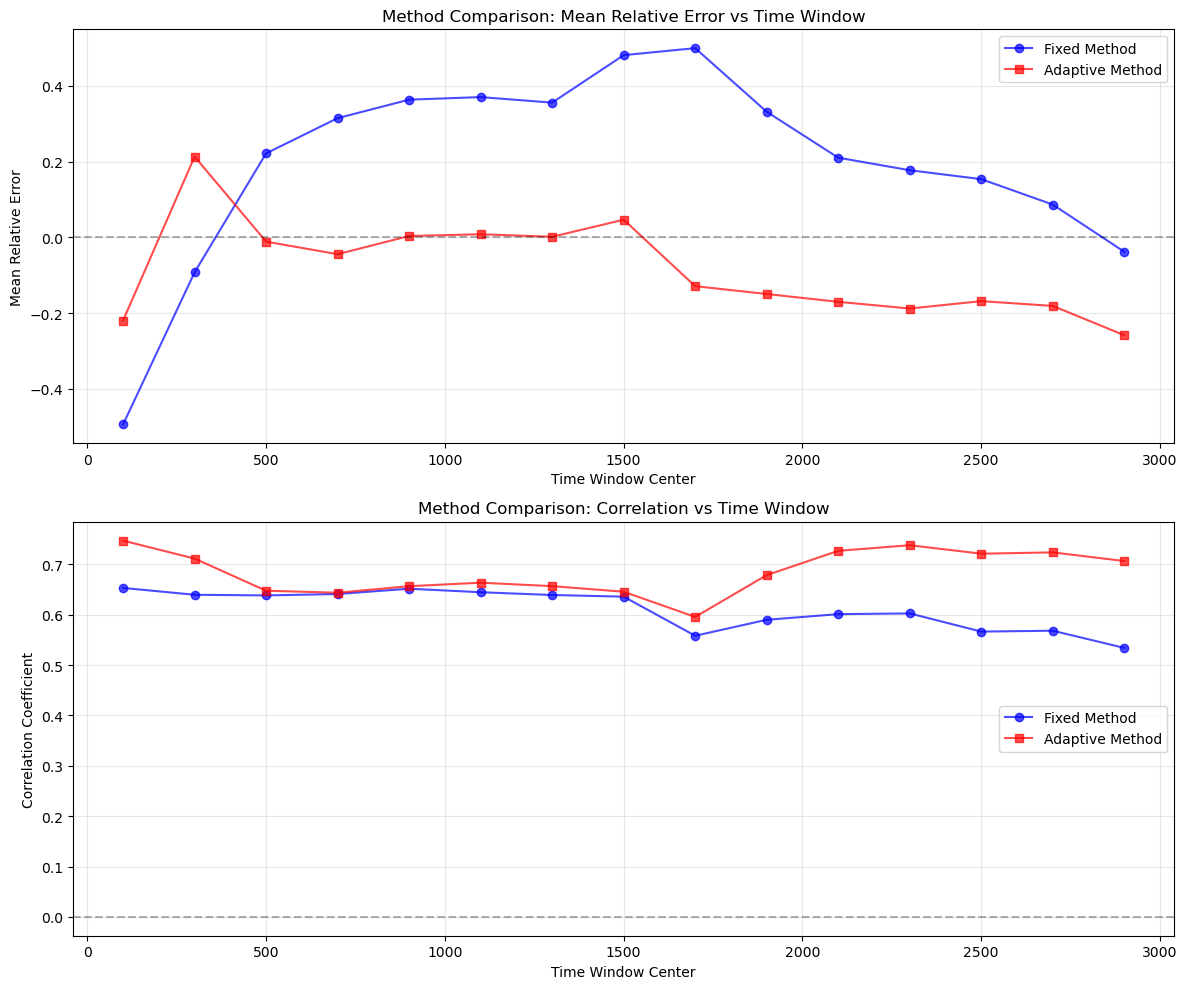

In [9]:
# Comparison plot (assuming you have fixed method results: window_centers, mean_relative_errors, std_relative_errors, correlations)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Mean Relative Error comparison
valid_fixed = ~np.isnan(mean_relative_errors)
valid_adaptive = ~np.isnan(mean_relative_errors_adaptive)

ax1.plot(window_centers[valid_fixed], mean_relative_errors[valid_fixed], 
         'o-b', alpha=0.7, label='Fixed Method')
ax1.plot(window_centers_adaptive[valid_adaptive], mean_relative_errors_adaptive[valid_adaptive], 
         's-r', alpha=0.7, label='Adaptive Method')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.set_xlabel('Time Window Center')
ax1.set_ylabel('Mean Relative Error')
ax1.set_title('Method Comparison: Mean Relative Error vs Time Window')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Correlation comparison
valid_corr_fixed = ~np.isnan(correlations)
valid_corr_adaptive = ~np.isnan(correlations_adaptive)

ax2.plot(window_centers[valid_corr_fixed], correlations[valid_corr_fixed], 
         'o-b', alpha=0.7, label='Fixed Method')
ax2.plot(window_centers_adaptive[valid_corr_adaptive], correlations_adaptive[valid_corr_adaptive], 
         's-r', alpha=0.7, label='Adaptive Method')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time Window Center')
ax2.set_ylabel('Correlation Coefficient')
ax2.set_title('Method Comparison: Correlation vs Time Window')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()